# SFML Project

Ward Gauderis - 0588485<br>
Fabian Denoodt - 0555582

Master Computer Science in Artificial Intelligence - Vrije Universiteit Brussel

## Introduction

This interactive research report is made by Fabian Denoodt and Ward Gauderis as part of the course Statistical Foundations of Machine Learning. The report is completely self-contained and the reader is encouraged to repeat our experiments and to modify them.<br>
In designing our three research questions, we have chosen topics that were mentioned in the course that we wanted to understand better or to investigate in more detail. The first question is about the influence of stochastic noise and regularisation on the trained model and is mainly examined by Ward with synthetic datasets and a simple neural network for classification. The second question is mainly investigated by Fabian using a synthetic dataset and attempts to provide insight into the role of different kernels in a support-vector machine. The last question is examined by both group members, with Fabian focusing on the first part and Ward on the second. It tries to shed light on two learning models for regression that were only touched upon during the lectures, k-nearest neighbour regression and decision tree regression, and how they perform for time-series forecasting with a real-world dataset.<br>
The full questions are:

1. What is the influence of stochastic noise in the dataset on the in- and out-of-sample error of a neural network and how does weight decay regularisation counter this?
2. How do the linear kernel, polynomial kernel and radial basis function compare to each other, when applied to a synthetic two-dimensional dataset?
3. How does the decision tree regressor model compare to the k-nearest neighbour regressor model in terms of in- and out-of-sample error for time series forecasting?

## Research Question 1

As a general research goal, we pose the following question

**What is the influence of stochastic noise in the dataset on the in- and out-of-sample error of a neural network and how does weight decay regularisation counter this?**

First, we explain every part of this research question in more detail before setting up the experiment, after this we present the measurement results and their interpretation.

We consider a synthetic dataset consisting of samples $(x, y)$ with $x \in \mathbb{R}^2$ and $y \in {0, 1}$ and set the classification task of predicting $y$ based on $x$. A synthetic dataset allows us to see noise as a controllable independent variable.<br>
Here, we only examine the influence of stochastic noise on the generalisability of the trained model.
Our definition of the dataset allows a further distinction between label noise and data noise. Label noise occurs when samples $x$ in the dataset are assigned incorrect labels $y$. In our case, symmetric label noise can be modelled in the dataset by swapping the labels of a percentage of samples. Data noise, on the other hand, relates to noise in the features x which in our case are continuous. This is modelled by adding a normally distributed error term $\epsilon \sim \mathcal{N}(0,\,\sigma^{2})$ to x to obtain $x' = x + \epsilon$.<br>
We ensure our model is able to approximate the target function $f(x) = y$ very accurately as to avoid confounding deterministic noise. Both stochastic and deterministic noise are responsible for the phenomenon of overfitting where the in-sample error decreases while the out-of-sample error increases. In general, this is combated by increasing the amount of training data or decreasing the model complexity.<br>
In this experiment, we are only interested in reducing model complexity through regularisation while keeping the amount of training data constant.
We investigate only the 'mathematical' regularisation method of penalising particular properties of the learned model $h$ using an augmented error. Instead of trying to minimise $E_{in}(h)$ we now try to minimise
$$E_{aug}(h, \lambda, \Omega) = E_{in}(h) + \dfrac{\lambda}{N}\Omega(h)$$
where $\lambda$ is the regularisation parameter determining the amount of regularisation and $\Omega$ is the regulariser. $N$ is the amount of training samples since more samples require less regularisation. In our case, we examine the influence of weight decay using the $L_2$-norm which transforms the equation into
$$E_{aug}(w) = E_{in}(w) + \dfrac{\lambda}{N} ||w||^2$$
for weights $w$ in the model. This type of regularisation promotes shrinking the weights during the training process.<br>
A perfect machine learning model to investigate this effect is the neural network as neural networks are a very powerful and flexible generalisation of the linear perceptron. This great approximation power comes with the downside of overfitting the data easily. Below follows a short explanation of the neural network's inner workings and learning process.

### Neural Networks

Neural networks are an extension of the perceptron model that classifies any point $x \in \mathbb{R}^(d)$ as
$$h(x) =sign(w^Tx + b)$$
using learned weights $w$ and bias $b$. This model is able to learn a linear decision boundary based on any linearly separable dataset using the PLA algorithm.<br>
The multi-layer perceptron is an extension of this model in which multiple perceptrons are chained behind each other in layers. Each layer itself can contain several perceptrons whose outputs are then served as 'features' into every perceptron in the next layer. The first layer 0 is the input layer containing the original features $x$ that is connected to 0 or more sequentially fully-connected hidden layers $l$ of which the outputs are propagated into (in our case) one final single perceptron in layer $L$. Making a classification is done through forward-propagation. <br>
In this way, the output of $L$ is the classification of $x$ done by the full model and non-linear target functions can be represented. The final prediction for $L$ layers could be represented as follows
$$h(x) = \theta(A_L(\theta(A_{L-1}(\theta(\dots(A_1x)))))$$
where $A_ix = W_i x + b_i$ is a linear transformation with weight matrix $W_i$ and bias vector $b_i$ for every layer and $\theta(x) = sign(x)$ is the activation function. Learning such a complex system with many weights is a hard combinatorial problem because the $sign(\cdot)$ activation function is not a smooth function.<br>
In a real neural network this activation function is therefore replaced by a similar sigmoid function (such as $\tanh(x)$) that is actually smooth and differentiable. This allows us to use analytic methods to learn the model.<br>
The most common method to learn a target function using a neural network is stochastic gradient descent. In normal 'batch' gradient descent, an error function
$$E_{in}(w) = \dfrac{1}{N} \sum_{n=1}^N e(h(x_n), y_n)$$
is minimised by taking iterative steps in the opposite direction of the gradient $\nabla E_{in}(w)$ at $w$ with respect to _all_ training samples
$$w \leftarrow w - \eta \nabla E_{in}(w)$$
for a certain learning rate $\eta$.
In stochastic gradient descent this happens for each _individual_ training sample instead of the full training set
$$w \leftarrow w - \eta \nabla e(h(x_n), y_n)$$
In expectation both variants of gradient descent will result in the same $w$ that minimises $E_{in}(w)$ but stochastic gradient descent is computationally cheaper, randomised and simpler.<br>
When applying this to the weights inside our neural network, we need a proper definition for the error on a sample $e(h(x_n), y_n)$. In our case, the network is used for binary classification by predicting the probability that $x$ is of class $y = 1$
$$h(x) = P(y = 1 | x)$$
based on which a discrete decision can then be made. The error to be minimised for this problem is the cross-entropy error (also called the logarithmic loss) which maximises the likelihood of the training data
$$\prod_{n=1}^N P(y_n | x_n)$$
Calculating the gradient of this function is not a straightforward task for a neural network but can be done efficiently by the so-called backpropagation algorithm which is able to calculate the partial derivative for each weight from back to front by making use of the chain rule.<br>
In this way, the neural network is able to approximate non-linear target functions through the combination of linear transformations and non-linear activation functions. One could view what the network does as learning the appropriate non-linear transformations on the input data $x$ that allow for a linear classification in this transformed space.

### Initialisation

Before starting our experiment we, create some useful helper functions for plotting scattered data points and decision boundaries in two dimensions.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

cmap = plt.cm.RdBu_r

def scales(ax: plt.Axes) -> (float, float, float, float):
    """
    Helper function to configure the axes
    :param ax: plot axes
    :return: x and y limits of the plot
    """
    x_min = -2
    x_max = 2
    y_min = -2
    y_max = 2

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("equal")

    return x_min, x_max, y_min, y_max


def plot_points(X: np.ndarray, y: np.ndarray, ax: plt.Axes) -> None:
    """
    Make a scatter plot of the points and their label
    :param X: features
    :param y: labels
    :param ax: plot axes
    :return: None
    """
    scales(ax)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=20)


def plot_decision_boundaries(X: np.ndarray, y: np.ndarray, ax: plt.Axes, model: Pipeline, resolution=0.02, decision=False) -> plt.Axes:
    """
    Plot the decision boundary of a sklearn model together with the data points
    :param X: features
    :param y: labels
    :param ax: plot axes
    :param model: sklearn model
    :param resolution: resolution of the contour plot
    :param decision: plot decisions or probabilities
    :return: ax
    """
    x_min, x_max, y_min, y_max = scales(ax)

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    if decision:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    else:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap=cmap, s=10)

    return ax

### Generating Synthetic Datasets

We create a function that makes it possible to generate two types of datasets in combination with varying noise parameters. One dataset resembles the two classes as two moons close to each other in the feature space while the other represents them as two concentric circles. The target function of the moon datasets could be considered a little more complex. The function allows for the addition of label noise, in which case up to 50% of the labels are randomly swapped, and data noise, in which case a normally distributed error in both axes is added to the features.

In [4]:
def make_datasets(moons: bool, data_noise: bool, label_noise: bool, min_noise: float, max_noise: float,
                  dataset_size: int, N: int) -> (
        list[(np.ndarray, np.ndarray)], np.ndarray):
    """
    Make N synthetic datasets ranging in noise value
    :param moons: make two moon shape classes of points or make two contained circular classes of points
    :param data_noise: Add Gaussian data noise to the features
    :param label_noise: Add label noise by swapping a percentage of labels
    :param min_noise: minimum noise value >= 0
    :param max_noise: maximum noise value >= 0
    :param dataset_size: amount of data points
    :param N: Amount of datasets to generate
    :return: A list of datasets and an array of noise values
    """
    datasets = []

    noises = np.linspace(min_noise, max_noise, N)
    for noise in noises:
        X, y = [],[]
        if moons:
            X, y = make_moons(dataset_size, random_state=0, noise=noise if data_noise else 0)
            X[:,0] -= 0.5
        else: 
            X, y = make_circles(dataset_size, random_state=0, noise=noise if data_noise else 0, factor=0.5)

        # Add label noise by swapping a fraction of labels corresponding to noise / 2
        # In this way, a noise value of 1 results in 50% of the labels being swapped
        if label_noise:
            for i in range(int(dataset_size * noise / 2)):
                y[i] = 0 if y[i] else 1

        datasets.append((X, y))
    return datasets, noises

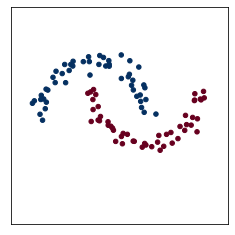

In [5]:
# Plot some moons with data noise
data, noises = make_datasets(True, True, False, 0.1, 0.1, 100, 1)
X, y = data[0]
plot_points(X, y,  plt.subplot())

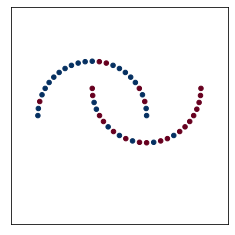

In [6]:
# Plot some circles with labeling noise
data, noises = make_datasets(True, False, True, 0.5, 0.5, 50, 1)
X, y = data[0]
plot_points(X, y,  plt.subplot())

### Generating Models

We now create a function that generates many neural network models for us with varying regularisation amounts.
Each model has been given two hidden layers of size 20 of with Relu activation functions to ensure that deterministic noise is as absent as possible.
The models run for 2000 epochs and are not allowed to stop early, because we don't want early stopping regularisation to interfere.
We use the _lbfgs_ optimiser which actually belongs to the family of quasi-Newton methods and not gradient descent methods because this method performs better for small datasets in terms of convergence speed.
All features are normalised with respect to the training data before given to the models.

In [7]:
def make_models(min_regularisation: float, max_regularisation: float, N: int) -> (list[Pipeline], np.ndarray):
    """
    Make N multi-layer perceptron models ranging in the amount of L2 regularization
    :param min_regularisation: minimum amount of alpha >= 0
    :param max_regularisation: maximum amount of alpha >= 0
    :param N: Amount of models to generate
    :return: A list of models and an array of alphas
    """
    models = []

    alphas = np.linspace(min_regularisation, max_regularisation, N)
    for alpha in alphas:
        models.append(
            make_pipeline(StandardScaler(), MLPClassifier(
                solver="lbfgs", # this optimiser performs best for small datasets
                hidden_layer_sizes=(20, 20), # two hidden layers of size 20
                max_iter=2000,
                early_stopping=False, # Avoid early stopping to investigate only the influence of weight decay
                random_state=0,
                alpha=alpha
            ))
        )
    return models, alphas

### Training and Plotting Decision Boundaries

This function makes it possible to train every generated model on every generated dataset and visualise a selection of the learned decision boundaries. Every dataset is split into a test and training set and both the training and test scores are calculated for every combination.

In [8]:
def train_and_plot(datasets: list[(np.ndarray, np.ndarray)], noises: np.ndarray, models: list[Pipeline],
                   alphas: np.ndarray, plots: int, samples: int, plot: bool = True) -> (list[float], list[float]):
    """
    Train every model on every dataset, calculate the training and testing error and plot a selection of the learned decision boundaries
    :param datasets: list of datasets
    :param noises: list of the amount of noise in every dataset
    :param models: list of models
    :param alphas: list of the regularisation parameter in every model
    :param plots: the amount of decision boundary plots on every axis to plot
    :param samples: the ratio of model/datasets that aren't plotted but only trained for error measurements
    :param plot: True if the plot needs to be made
    :return: A list of training errors and a list of testing errors
    """
    # index of the next plot to make
    i = 1
    plt.figure(figsize=((plots + 1) * 3, plots * 3))

    train_scores = []
    test_scores = []

    for dataset_index, ((X, y), noise) in enumerate(zip(datasets, noises)):
        # Split the data into training and testing data
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.4)

        # Plot the dataset if required
        if dataset_index % samples == 0:
            ax: plt.Axes = plt.subplot(plots, plots + 1, i)
            i += 1

            plot_points(X, y, ax)

            ax.set_ylabel(f"Noise: {noise:.2f}", fontsize=15)

        for model_index, (model, alpha) in enumerate(zip(models, alphas)):
            print(f"{dataset_index + 1}/{len(datasets)} datasets, {model_index + 1}/{len(models)} models", end="\r")

            # Fit the model to the training data
            model.fit(X_train, y_train)

            # Calculate the training and testing score
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))

            # Plot the decision boundary if required
            if dataset_index % samples == 0 and model_index % samples == 0:
                ax: plt.Axes = plt.subplot(plots, plots + 1, i)
                i += 1

                plot_decision_boundaries(X, y, ax, model)

                if dataset_index == 0:
                    ax.set_title(f"Regularisation: {alpha:.2f}", fontsize=15)

    plt.suptitle("Learned decision boundaries")
    if not plot:
        plt.close()

    return train_scores, test_scores

### Plotting the Accuracy Scores

Most importantly, as we want to compare the influence of regularisation and noise on the training and test scores, this function creates a contour plot for both scores as dependent variables. The amount of noise and regularisation are the independent variables.

In [9]:
def score_contour_plot(noises: np.ndarray, alphas: np.ndarray, train_scores: list[float], test_scores: list[float]):
    """
    PLot a contour plot of the training and testing scores for every combination of noise and regularisation
    :param noises: array of noise values
    :param alphas: array of regularisation amounts
    :param train_scores: training scores for the corresponding datasets and models
    :param test_scores: testing scores for the corresponding datasets and models
    :return:
    """
    xx, yy = np.meshgrid(alphas, noises)

    plt.figure(figsize=(3 * 4, 2 * 4))
    i = 1
    for data, title in [(train_scores, "Training Score"), (test_scores, "Test Score")]:
        ax: plt.Axes = plt.subplot(1, 2, i)
        ax.set_title(title)
        ax.set_ylabel("Noise")
        ax.set_xlabel("Regularisation")
        z = np.reshape(data, xx.shape)
        c = ax.contourf(xx, yy, z, np.linspace(z.min(), z.max(), 20), cmap=cmap)
        ax.invert_yaxis()
        i += 1

    plt.colorbar(c, ax=plt.gcf().axes, orientation="horizontal")
    plt.suptitle("Contour plot of the scores")

### Setting up the Experiments

We now set up some experiments. By default, we generate 13 datasets and models, varying in noise and regularisation. For a sample of $5^2 = 25$ combinations, the learned decision boundaries will be plotted. The resolution of the resulting score contour plot can be increased by increasing the _samples_ parameter. We vary the noise level between 0 and 0.75 and the amount of regularisation between 0 and 1.5. Every dataset contains 100 samples. Feel free to adjust these parameters to experiment or reduce the running time of the experiments.

In [10]:
# Amount of decision boundary plots to make on every axis
plots = 5
# Amount of samples that need to be made in between every plot
# More samples result in a higher resolution score contour plot
samples = 3
# Calculate the total amount of datasets and models to generate
# DON't CHANGE
N = (plots - 1) * samples + 1

# The minimum and maximum amount of stochastic noise to test
min_noise = 0
max_noise = 0.75

# The amount of points in every dataset
dataset_size = 100

# The minimum and maximum amount of regularisation to test
min_regularisation = 0
max_regularisation = 1.5

# Create all the models with different alphas
models, alphas = make_models(min_regularisation, max_regularisation, N)

### Results and Interpretation

We now run our experiment on a moon dataset with only data noise.

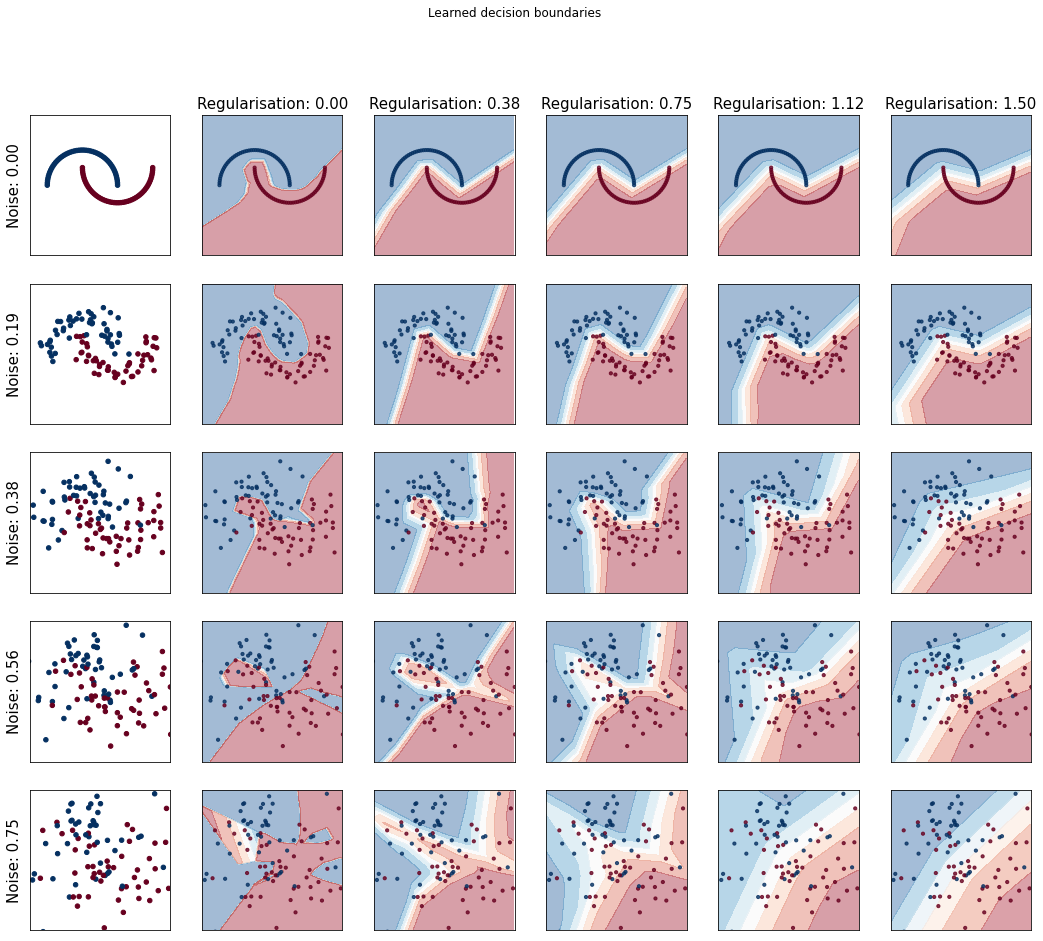

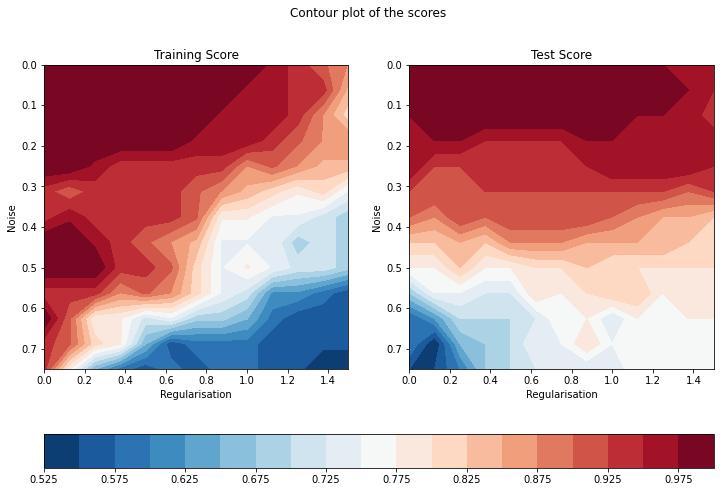

In [11]:
# Create a moon dataset with only data noise
datasets, noises = make_datasets(True, True, False, min_noise, max_noise, dataset_size, N)
# Train the models on every dataset and plot a selection of the resulting decision boundaries
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples)
# Plot the influence of noise and regularisation on the scores in a contour plot
score_contour_plot(noises, alphas, train_scores, test_scores)

As we can observe in the top left corner of the decision boundary plot (which actually is a plot of the probability $P(y=1|x)$), without any noise or regularisation the model is perfectly able to approximate the target function. However, when we examine the plots going down where the value of noise increases, the model starts to overfit more and more until the original target function is no longer recognisable.<br>
When we look to the plots on the right where the amount of regularisation increases, we see that the decision boundary still resembles the target function but in a constrained way. Looking down now also at the plots where both noise and regularisation are present, we can observe that the target function remains recognisable for longer. Although this is no longer the case when the regularisation parameter is too high.

Drawing conclusions only by looking at decision boundaries is hard. The second figure helps us by displaying the influence of data noise and regularisation on the training score, left, and testing score, right.
Unexpectedly, the training score does not go down when we only increase the noise level but the testing score does drop to almost 50% accuracy. This is a classic example of overfitting where the data noise is learned by a model that is too complex for the amount of available training data.<br>
However by forcing the complexity of the model down through regularisation, a high test score of about 75% can still be obtained even for a lot of data noise. When doing this, the training score does go down because the gradient descent algorithm is minimising a loss function that deviates more and more from the actual error by giving more importance to small weights.<br>
On the other hand, high regularisation levels do perform less well on datasets with low amounts of data noise, both in training and test score. This could be seen as a signal of underfitting.

We now repeat the experiment for a circular dataset to ensure these results are not completely specific to the construction of the moons.

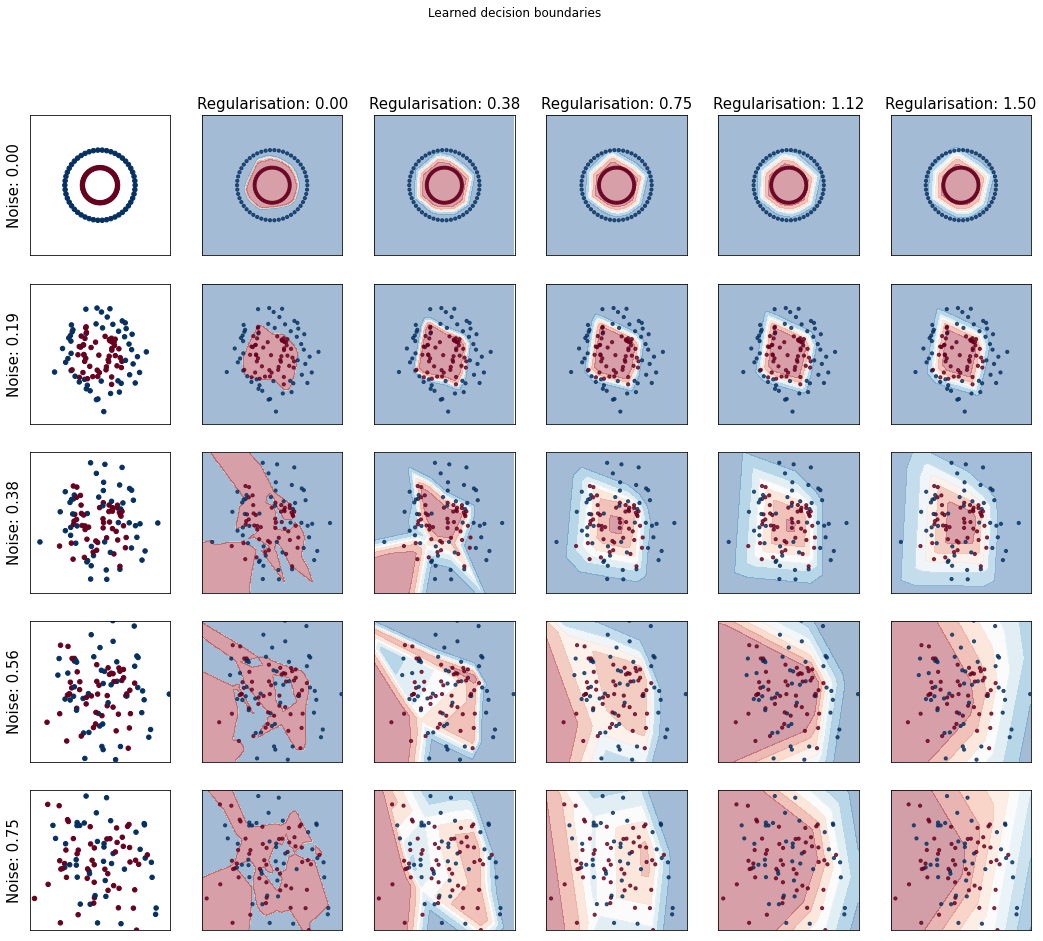

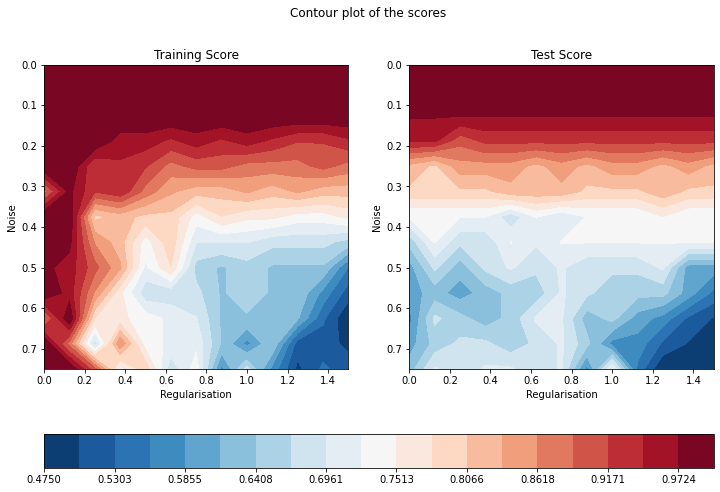

In [12]:
# Repeat the experiment for a circular dataset with only data noise
datasets, noises = make_datasets(False, True, False, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples)
score_contour_plot(noises, alphas, train_scores, test_scores)

When looking at the decision boundary plots, the importance of the right amount of regularisation becomes even clearer. When increasing the amount of data noise, models with both low and high regularisation completely fail to approximate the target circular function. However, for a regularisation amount of 0.75, the initial circle still remains recognisable.

Turning to the score contour plot, we notice that higher amounts of regularisation do not decrease the testing performance as much as for the moons dataset. Underfitting here is harder to do for a simpler target function. Training scores however do drop really fast starting from a data noise level of 0.4.<br>
For low noise levels, the contour lines of the testing scores are nearly horizontal, but for higher values, a regularisation amount of approximately 0.6 seems to perform best with a testing score of about 70%. Both using less or more regularisation gets punished quickly.<br>
Noticeable here is that higher regularisation amounts actually perform better for lower noise levels of about 0.4.

We now repeat the two experiments for datasets with labeling noise only. We omit the decision boundary plots for brevity (they can be displayed again by toggling the _plot_ boolean).

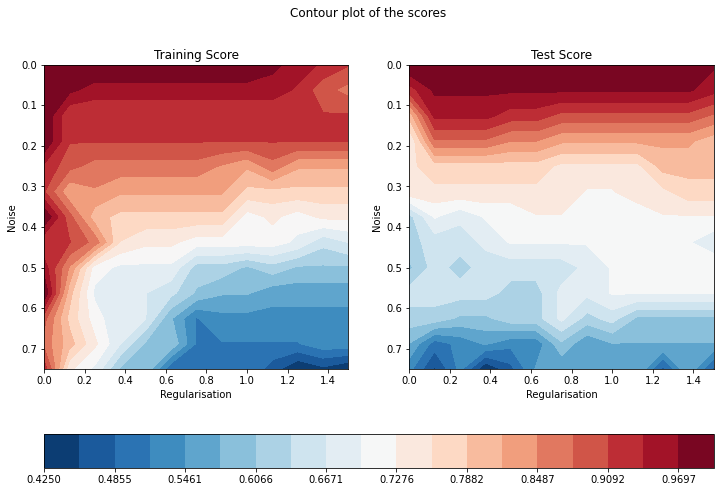

In [13]:
# Repeat the experiment for a moon dataset with only label noise
datasets, noises = make_datasets(True, False, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

Clearly, label noise is much more detrimental to the testing accuracy of our model, although scores between 0.6 and 0.7 are still achievable for reasonable amounts of noise. We notice a similar trends in training scores where the scores suddenly drop very quickly when even a little amount of regularisation is used for noise levels above 0.4. In general, even slightly regularised models seem to perform better here.

We now show the influence of label noise on the circular datasets.

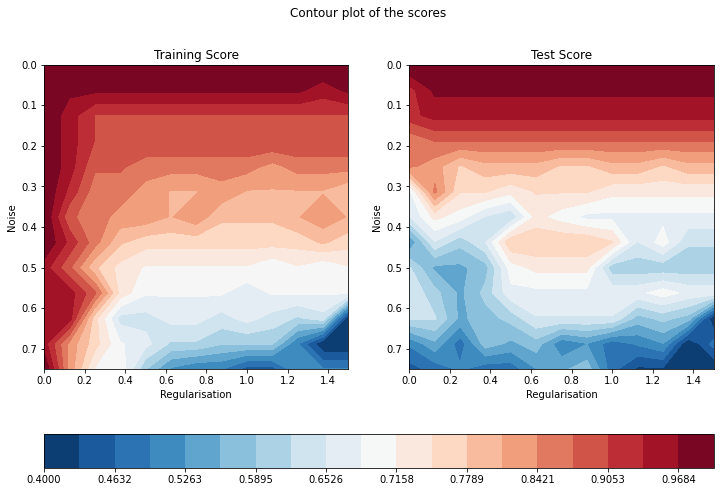

In [14]:
# Repeat the experiment for a circular dataset with only label noise
datasets, noises = make_datasets(False, False, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

In comparison to the more complex moon datasets, label noise destroys the generalisability of the models less. Although for extreme values, the model almost becomes better at predicting the wrong labels on the testing data.<br>
The training scores seem to evolve in a similar way. But when we look at the test score, we observe a perfect example of both underfitting and overfitting. For relatively high noise levels about 0.4, there exists almost this peninsula where the testing score remains above 75% for regularisation values between 0.6 and 0.8. This phenomenon is not distinguishable in the training error.

We now repeat the experiment for the combination of both data and label noise on both types of datasets.

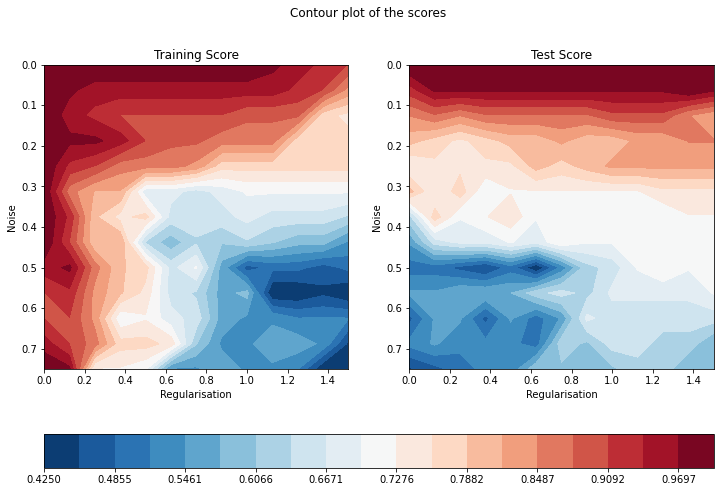

In [15]:
# Repeat the experiment for a moon dataset with both data and label noise
datasets, noises = make_datasets(True, True, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

When combining the two stochastic noise types, one might expect the testing score to drop much faster.
But for reasonable noise and regularisation values, the models are still able to generalise with an accuracy of about 70%.<br>
In this case, the training and testing accuracy graphs are almost mirrored, further indicating that the training score becomes almost irrelevant for estimating the testing error when regularisation levels increase.

Below we show the experiment repeated for the simpler circular dataset.

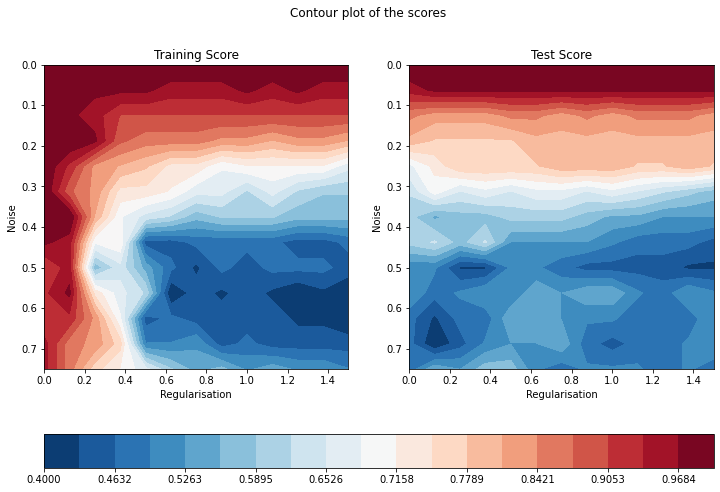

In [16]:
# Repeat the experiment for a circular dataset with both data and label noise
datasets, noises = make_datasets(False, True, True, min_noise, max_noise, dataset_size, N)
train_scores, test_scores = train_and_plot(datasets, noises, models, alphas, plots, samples, plot=False)
score_contour_plot(noises, alphas, train_scores, test_scores)

In the case of the circular dataset, combining much label and data noise becomes too much for any model to handle, regardless of regularisation. The testing accuracy averages around 0.55 while the training score plot remains similar to previous experiments.<br>
In the testing plot, we observe almost horizontal contour lines resembling a sandy exotic beach with a deep blue ocean below dotted with a small archipelago around regularisation levels between 0.4 and 0.8.... Maybe it's time for a summer holiday :)

### Conclusion

From our experiments, we can conclude that simpler neural networks with a lower amount of effective parameters generalise much better when trained on increasingly noisy datasets. One way such models can be obtained is by modifying the loss function that is minimised by gradient descent. Weight decay is a valid option as regulariser in the augmented error.<br>
Stochastic noise is more detrimental to the testing error when little data is available. The model will overfit the data more than warranted, including the noise.<br>
The presence of label noise generally has a bigger effect on the generalisability of the model, but can already be combated with low regularisation amounts. Data noise, on the other hand, decreases the test scores more gradually and higher regularisation amounts may be required. However, in practice, label noise may occur less frequently in a dataset than data noise.<br>
One must be careful not to underfit the data by reducing the complexity of the model too much. Although in our experiments, this seemed to be less disastrous than overfitting the data without regularisation.<br>
We also observed that models trained on datasets of simpler target functions may be more susceptible to noise, but require less regularisation to be corrected.<br>
The right amount of regularisation can have a very positive effect on the generalisability of your model.
But in reality, this perfect regularisation value is hard to know, as estimating the amount of noise and complexity of the dataset at hand
is hard to do without data snooping and contamination. One should choose the model complexity based on the amount of data available, not based on the target complexity.<br>
Our experiments also indicate that the in-sample error becomes less and less informative about the true out-of-sample error as the amount of weight decay increases. This can be explained by the fact the loss function optimised by the gradient descent algorithm is no longer the same as the original error measure.<br>
These results only illustrate further the importance of doing correct model validation to estimate the optimal regularisation parameter for your model trained on noisy data.

## Research Question 2

**How do the linear kernel, polynomial kernel and radial basis function (RBF) compare to each other, when applied to a synthetic two-dimensional dataset?**

In this section we will investigate how well the three kernels manage to fit a non-linear data set. We will also try to get a grasp of generalisation by comparing the number of support vectors each of the kernels create.


Similar to the Perceptron Learning Algorithm (PLA), Support venture machines (SVM) classify binary data by separating data in two groups. However, instead of trying to create a hyperplane that works, SVM calculates the hyperplane that best separates the data. Its objective is thus to find the hyperplane that maximizes margin between the two categories. (It is thus an optimization problem)

![image-20220514162339201](https://i.imgur.com/VFGydWz.png)

The way this largest margin is achieved, is by maximizing the distance between the hyperplane and the closest data point to the line. This distance can be expressed as the following equation:
$$
\frac{1}{\mid\mid \mathbf{w}\mid\mid}
$$
which can be expressed as a minimization problem via the following equation:
$$
\frac{1}{2}\mathbf{w}^T\mathbf{w}
$$
Subject to the following constraints (assuming the data is linearly separable):
$$
y_n(\mathbf{w}^T\mathbf{x_n} + b) >= 1
$$


The minimization problem is solved by formulating it as a Lagrange minimization problem and by applying quadratic programming to obtain the vector $\mathbf{\alpha}$. This vector $\mathbf{\alpha}$ enables us to compute the weights as follows:
$$
\mathbf{w}= \sum_{x_n \in \text{ SV}}{\alpha_n y_n \mathbf{x_n}}
$$


**Non linear data**

Although the default SVM approach works well for linearly separable data, non-linearly separable data must be transformed to another dimension to make it separable. An example of such data is shown in the image below.

![image-20220514170712418](https://i.imgur.com/40tUqQ9.png)

The first drawback of these space transformations is that someone must choose what the non-linear transformation should be. The second problem is that when a complex decision boundary is required, the complexity of the transformation increases, which increases computational requirements. The kernel trick is meant to solve these issues. When we look at the Lagrange equation below, via quadratic programming the alpha's can be obtained. A dot product must be calculated for each data point in the transformed space. The higher the dimension of the space, the more complex the computation becomes. The kernel trick prevents having to calculate this dot product, allowing for transformations to infinite dimensional space.
$$
\mathcal{L}(\mathbf{\alpha}) = \sum_{n=1}^{N} \alpha_n-\frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N} y_ny_m\alpha_n\alpha_m\mathbf{z_n}^T \mathbf{z}_m
$$



In what follows next, we investigate the following research question: "*How do the linear kernel, polynomial kernel and radial basis function (RBF) compare to each other, when applied to a synthetic two-dimensional dataset*?"




Linear kernel, which is equivalent to the default SVM explained above:
$$
K(\mathbf{x}, \mathbf{x}') = \mathbf{x}^T \mathbf{x}'
$$
Polynomial kernel:


$$
K(\mathbf{x}, \mathbf{x}')=(1 + \mathbf{x}^T\mathbf{x}')^Q
$$

Radial basis function:
$$
K(\mathbf{x}, \mathbf{x}') = e^{-\gamma \mid\mid \mathbf{x}-\mathbf{x}' \mid\mid^2}
$$



In [17]:
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
from numpy import pi

In [18]:
# https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def create_svm_and_plot(model, X, y, kernel='linear'):

    clf = model.fit(X, y)

    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of {} SVC '.format(kernel))
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('y label here')
    ax.set_xlabel('x label here')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    # ax.legend()
    plt.show()
    return clf

### Data
Via the cosine, sinus function and some added noise, the data set is generated. The plot below demonstrates how the data takes the form of a spiral. 800 data points are generated, 400 for each class.

In [19]:
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 400

np.random.seed(42)
theta = np.sqrt(np.random.rand(N)) * 2 * pi  # np.linspace(0,2*pi,100)

r_a = 2 * theta + pi
data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
x_a = data_a + np.random.randn(N, 2)

r_b = -2 * theta - pi
data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
x_b = data_b + np.random.randn(N, 2)

res_a = np.append(x_a, np.zeros((N, 1)), axis=1)
res_b = np.append(x_b, np.ones((N, 1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

N = N * 2 # 400 datapoints for each class, so 800 points total
X = res[:, 0:2]
y = res[:, 2]

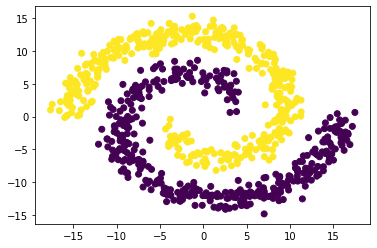

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [21]:
# We split the data into two sets, one for training and a second set for model testing.

N_train = int(N * 0.8)
N_test =  int(N - N_train)

X_train = X[0:N_train-1]
y_train = y[0:N_train-1]

X_test = X[N_train:]
y_test = y[N_train:]

To demonstrate the difference between the three kernels, we have opted for a non linear dataset that is separable. We use the following 2 dimensional spiral dataset.

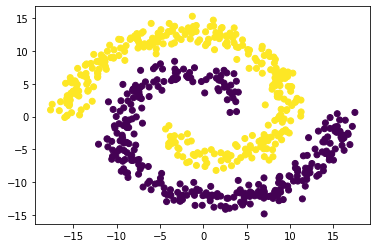

In [22]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

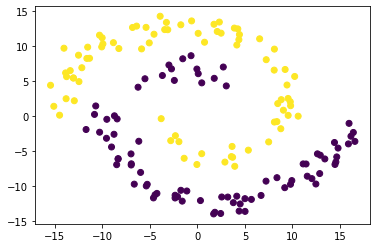

In [23]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

### Implementation of the kernels using Sklearn

Sklearn implements SVM using a soft margin, however, since the synthetic dataset is actually separable a strict margin is preferred. To obtain this stricter margin, we must provide a high C value. When C goes to infinity, we again, obtain the strict margin. Changing the C value corresponds to changing the C value in the following minimization problem
$$
\frac{1}{2}\mathbf{w}^T\mathbf{w} + \sum_{n=1}^{N} \zeta_n
$$
Where
$$
\sum_{n=1}^{N} \zeta_n
$$

corresponds to the total violation. This is a quantification for the points that inside the margin, and thus violate the margin.

<img src="https://miro.medium.com/max/916/1*UylttRyv51Pz0ADkNt4goA.png" alt="Support Vector Machine Explained. Theory, Implementation, and… | by Zixuan  Zhang | Towards Data Science" width=200 />



Indeed, when C goes to infinity, this is equal to solving the minimization problem for the strict margin. (Which was discussed above)
$$
\frac{1}{2}\mathbf{w}^T\mathbf{w}
$$


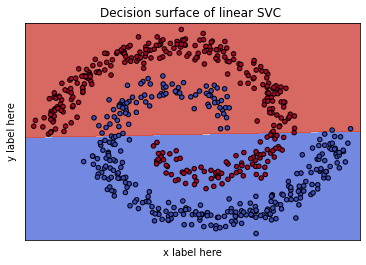

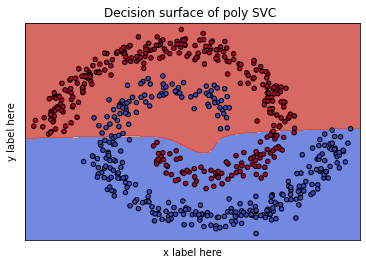

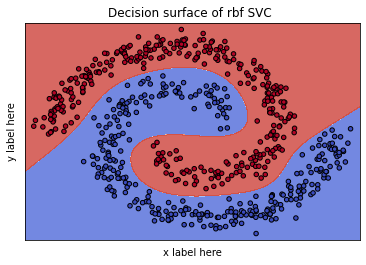

In [24]:
linear = create_svm_and_plot(svm.SVC(kernel='linear', C=1000), X_train, y_train, 'linear')
create_svm_and_plot(svm.SVC(kernel='poly', C=1000), X_train, y_train, 'poly')
rbf = create_svm_and_plot(svm.SVC(kernel='rbf', C=1000), X_train, y_train, 'rbf')

### Results and interpretation
The three graphs above display each display the decision boundary of a specific kernel. The plotted data points conist of the training set. From the graph we can see there is a clear difference in the flexibility between the three kernels. The linear kernel is only able to separate the data by drawing a single line. It is clearly not able to replicate the spiral shape of the training set. In the case of the polynomial kernel, by default Sklearn uses a number of degrees equal to three. This value corresponds to the $Q$ in the polynomial kernel mentioned above. The higher the number of degrees, the more flexible the decision boundary becomes. Although the polynomial kernel with degree = 3, does not split the data correctly, the shape of its decision boundary is more similar the spiral shape than the linear linear decision boundary. We try higher degrees of freedom later. Note that the higher the degrees, the more prone the model is to overfitting. From the third graph above, we can see that the RBF kernel manages to fit the training set really well. 

The parameter Gamma $\gamma$ was left unchanged since the default value obtained the best results.

#### Different parameters for $Q$ in the polynomial kernel 
Lastly, we try different degrees of freedom for the polynomial kernel. We fit models with the following degrees: 5, 10, 15, 20, 30. As can be seen in the five graphs below, none of the models manage to imitate the training set as well as the rbf kernel did. Although none of polyonial SVM models managed to imitate the trend of the training set well, we note that the models where $Q$ = 20 and 30, are really overfit.

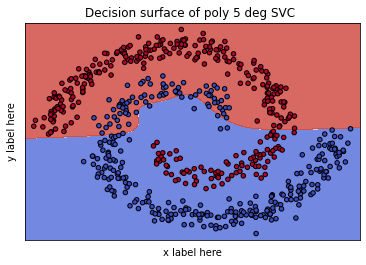

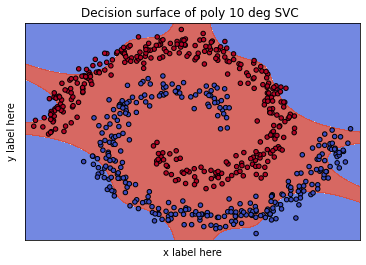

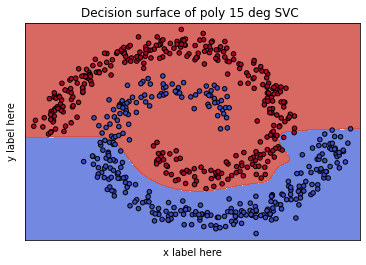

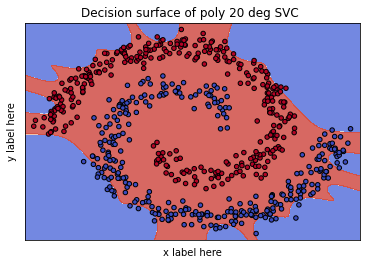

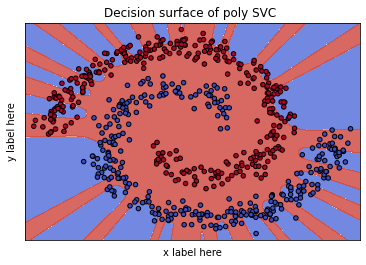

In [25]:
create_svm_and_plot(svm.SVC(kernel='poly', degree=5, C=100), X_train, y_train, 'poly 5 deg')
create_svm_and_plot(svm.SVC(kernel='poly', degree=10, C=100), X_train, y_train, 'poly 10 deg')
create_svm_and_plot(svm.SVC(kernel='poly', degree=15, C=100), X_train, y_train, 'poly 15 deg')
create_svm_and_plot(svm.SVC(kernel='poly', degree=20, C=100), X_train, y_train, 'poly 20 deg')
poly_30_deg = create_svm_and_plot(svm.SVC(kernel='poly', degree=30, C=100), X_train, y_train, 'poly')

### Comparison of kernels on the test set:
We compare the generalization of the models by testing them on unseen data. The performance/accuracy of the models are quantified using the Sklearn `score` metric. Since target values are binary (either +/-), the performance corresponds to the average number of correctly predicted data points. And thus accuracy corresponds to $1 - \text{Error}$.

By looking at the accuracies measured on the testing data set, we note that the rbf model obtains an accuracy of 98%, the linear model comes in second with an accuracy of 78% and lastly, the overfit 30 degree polynomial model obtains an accuracy of 46%.

It is worth mentioning that although the linear model did not manage to immitate the spiral trend of the data (because of its restricted degrees of freedom), in the model still performs quite well based on its accuracy. 

In [26]:
print(linear.score(X_test, y_test))
print(rbf.score(X_test, y_test))
print(poly_30_deg.score(X_test, y_test))

0.78125
0.9875
0.4625


### Generalisation ($\text{E}_{out}$)
It is also interesting to look at the number of support vectors that are required to obtain the decision boundary. This has great implications for generalization. Using the formula
$$
\mathbb{E}[E_{out}] \le \frac{\mathbb{E}[\text{# of SVs}]}{\text{N} - 1}.
$$


In [27]:
print("Number of elements: " + str(N))
print("Number of support vectors for the linear SVM: " + str(len(linear.support_vectors_)))
# print("Number of support vectors for the 30 degree polynomial SVM: " + str(len(model.support_vectors_)))
print("Number of support vectors for the 30 degree polynomial SVM: " + str(len(poly_30_deg.support_vectors_)))
print("Number of support vectors for the RBF SVM: " + str(len(rbf.support_vectors_)))

Number of elements: 800
Number of support vectors for the linear SVM: 371
Number of support vectors for the 30 degree polynomial SVM: 492
Number of support vectors for the RBF SVM: 15


In the case of the rbf SVM, assuming that  $\mathbb{E}[\text{# of SVs}] = 15$, we can say the expected value of $E_{out}$ is less than or equal to 1.8%. This is a great result! This error quantity is really close to the error value of 1.2% we obtained on the testing set earlier $(1-0.9875)$. By looking at the number of support vectors for the linear and polynomial kernels, we can say they do not perform as well on the generalization bound.

Note: Please keep in mind that the assumption that $\mathbb{E}[\text{# of SVs}] = 15$ is not entirely correct. To obtain more precise results, the number of SVs should be calculated multiple times.

In [28]:
print("E[E_out] <= " + str(len(rbf.support_vectors_)/(N-1)))
# generalization bound only holds if we assume E[# of SVs] = 15, which we can't really take for granted. Multiple runs must be done to conclude this statement.

E[E_out] <= 0.01877346683354193


### Conclusions
We have compared the RBF, polynomial and linear kernel to a non linear data set. We looked at how well each model was able to fit the spiral properties of the data set. We then compared the three different models on a test set in terms of accuracy.
We conclude that the RBF model performs better than the polynomial and linear on the spiral data set. The RBF model managed to create a decision boundary that replicated the original spiral well. It also obtained an accuracy on the test of almost 99%.

Although the linear model was not able to obtain a decision boundary in the same spiral form as the one from the data set, the model still obtained an accuracy of 78% on the test set.

Lastly, we tested multiple SVM models using the polynomial kernel, each with a different number of degrees of freedom ($Q$). None of the models managed to replicate the spiral form. The accuracy on the test set of the model with degrees of freedom equal to thirty, obtained an accuracy on the test set of 46%.


# Research Question 3

**How does the decision tree regressor model compare to the k-nearest neighbour regressor model in terms of in- and out-of-sample error for time series forecasting?**

Decision tree regression (DTR) and K-nearest neighbor (KNN) are two techniques for solving regression problems. Both models have the great advantage of being transparent in how predications are obtained. They, however, differ vastly in the way their regression hypothesis is obtained. DTR makes its predictions based on a model it learned, while KNN does not learn a model at all, the data is the model.

In this section we will compare the two techniques on a real world data set in terms of in- and out-of-sample error. Let us first get a better understanding of the workings of these two techniques.



# Decision tree regression

Decision trees have implementations both for classification (classification trees) and for regression (regression trees). In what follows we will explain the workings of the regression case. The decision tree algorithm produces a model that can be used for predictions. Given an input $\mathbf{x}$, the model obtains a prediction $\hat y$ by following a series of decision rules.

The model can be represented as a tree, where each **internal node** corresponds to a decision. Internal nodes have one incoming edges and out-going edges, labeled with the choose of a decision. The **leaf nodes** represent the final outcome of the prediction ($\hat y$). In the classification case, those outcomes are categorical, while in the regression case, the leaves represent a numeric value.

By starting from the **root node** and following the path to a leaf node, a $\hat y$ value can be obtained given an input $\mathbf{x}$. The image below displays an example of a regression tree.

<img src="https://i.imgur.com/7WTkosB.png" alt="Example of a regression tree (Panel a), with the partition of the... |  Download Scientific Diagram" width=400 />

Source: [(PDF) Using Regression Tree Ensembles to Model Interaction Effects: A Graphical Approach (researchgate.net)](https://www.researchgate.net/publication/325712556_Using_Regression_Tree_Ensembles_to_Model_Interaction_Effects_A_Graphical_Approach/figures?lo=1)



Let us now investigate how the algorithm works to obtain its regression trees. We will explain this by means of an example. We must predict the weight of people given their height, shoe size and gender.
$$
\mathbf{x} = \text{<?height, ?shoe size, ?gender>}
\\
y = \text{?weight}
$$
To build the decision tree, the algorithm must first decide on what its root node should be. Let's assume a node contains the following structure: "X is less than y", where X corresponds to a feature of the dataset and y corresponds to a certain threshold. An example node could then be: " *weight is less than 45*".  When deciding upon a node, there are two questions to ask, 1)  What should the threshold be? and 2) What feature should we use? (eg: weight or shoe size)

1. **What should the threshold be?**

   A plot of the height in relationship to the weight may look something like this:

   ![image-20220602194437933](https://i.imgur.com/tQcFrFR.png)

   Source: [The Relationship Between Human Height and Weight – GeoGebra](https://www.geogebra.org/m/RRprACv4)



   To select the optimal threshold, the data is split into two half's, from each half the mean is calculated. For each data point the distance is calculated to its respective mean, this is called the residual. By squaring those residuals and summing them up the squared residuals are obtained. The objective is to minimize the sum of squared residuals. We demonstrate this in the following example.

   In the graph, a potential threshold could for example be right in the middle at height = 55 inches. Splitting the data into two parts at height = 55 and calculating the mean weight values of the data points on the left side and the mean of the data points on the right side may look as follows:

   ![image-20220602195415563](https://i.imgur.com/rcQwnDm.png)

   The sum of squared residuals on the left side will be rather small for the left side, however the sum of squared residuals on the right side will be larger. This is because sum of the y-distance to the left mean is smaller than the sum of y-distances to the right mean. If we calculate the sum of the left and right residuals, we may not have minimized it in this case.

   However, if we had selected a different threshold (eg height = 65), the sum of squared residuals on the left side may be a little higher, but the total sum of squared errors (left + right) will be lower! This is thus a better threshold.

   ![image-20220602195934856](https://i.imgur.com/S8RBFDU.png)

    The algorithm selects the threshold that minimizes the total sum of squared errors.



2. **What feature should we use?**

   Similar to what we have done to obtain the perfect threshold, the best feature is selected by trying out different thresholds and selecting the feature that has the smallest sum of squared residuals.

   Note that this strategy also works for categorical values. To obtain the best sum of squared residuals for gender for example, there is only one threshold to be tested.

   ![image-20220602203133222](https://i.imgur.com/SjFy4mo.png)



**Overfitting**

The default behaviour of the decision tree regressor is to keep splitting the data into smaller groups until they can not be split any further. (Eg: all data points that correspond to a particular leave have the same value as the mean). This will cause the model to perfectly fit the training data, but the model will be severally overfit. This overfitting can be mitigated by setting a minimum on the number of data points that belong to a particular group. What is often done for example, is to set the minimum number to 20 for each leave. If a node has less than 20 data points, it will not be split further and instead take the mean of those data points as its output. By doing we, we limit how deep branches of the tree can grow.

The image below displays the predictions of two regression tree models that were trained on a noisy sine wave. What we can see that the result of decision tree regression is not a smooth continuous function such as a polynomial, but instead a function with many straight edges. This comes from the fact that similar data points are grouped the average of their target values is taken. Here we can also see how limiting the depth of the tree, will cause more elements to be grouped together, which prevents overfitting.



![../_images/sphx_glr_plot_tree_regression_001.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png)

Source: [1.10. Decision Trees — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/tree.html#tree)



Although, model predictions are really fast (logarithmic in the number of data points used to train the tree), one of the disadvantages of decision trees are that they take a long time to train. Learning an optimal decision tree is an NP-complete problem and thus decision-tree learning is based on greedy heuristics algorithms that do not guarantee a global optimal solution. We will see that K-NN mitigates this problem by not training a model at all.

Source: [1.10. Decision Trees — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/tree.html#tree)



# KNN regression

Just like decision trees, KNN can be used for both classification and regression. KNN, however, differs vastly from decision trees in the way the predictions are obtained. Instead of training a model and letting the model do the predications, in KNN the data is the model.

KNN has the advantage that it is a lot simpler than decision trees. The idea behind KNN is that given an input $\mathbf{x}$, the target value $y$ is obtained by looking at all k data points in $\mathbf{x}$'s neighborhood. This neighborhood contains all the k data points that are the most similar to $\mathbf{x}$. The output of the KNN algorithm depends on whether it is doing classification or regression.  In the case of classification, the target value for $\mathbf{x}$ is obtained by selecting the mode of the target values in its neighborhood. In the regression case, the average value of the neighborhood's target values is selected as output.

The image below visually illustrates the workings of the KNN algorithm. In the example k = 1 and thus the neighborhood only contains one point. The algorithm would thus select the target value of the star within the circle as it's output for $\mathbf{x}$.

![image-20220602211346211](https://i.imgur.com/2cBh9vx.png)

Source: [KNN Classification Tutorial using Sklearn Python | DataCamp](https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn)


The distance can be calculated via different metrics:

- **Minkowski Distance**
  $$
  d(\mathbf{x}, \mathbf{y}) =(\sum_{i=1}^n\left| x_i - y_i \right| ^p)^\frac{1}{p}
  $$
  The parameter $p$ allows us to manipulate the behaviour of the distance function. For example, when $p$ is set equal to 2, the distance corresponds to the euclidian distance. If $p$ is set to 1, the result corresponds to manhattan distance.



- **Euclidean Distance**
  $$
  d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^{n}{{(x_i - y_i)^2}}}
  $$


- **Manhattan Distance**
  $$
  d(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n}{{\left|x_i - y_i\right|}}
  $$


  The image below graphically displays the difference between the manhattan and euclidian distance metrics.

  ![Manhattan Distance Calculator](https://uploads-cdn.omnicalculator.com/images/manhattan_distance.png?width=425&enlarge=0&format=jpeg)



The nearest neighbors can be computed using different algorithms. Sklearn offers BallTree, KDTree or a brute for search. These are algorithms used to structure data in multidimensional space. Both the BallTree and KDTree algorithms structure their data in the form of a tree. Both algorithms require a leaf size parameter, which influences the speed of construction and the required memory of the tree.

### Training data description

To investigate the research question, we use a Kaggle dataset containing many in-house measurements of temperatures and humidities, as well as weather data and appliances energy consumption. For our goal, we focus
on predicting the humidity in the kitchen (in percentages) based on the other measurements.

The data contains 15000 measurements from the period 01/11/2016 until 24/04/2016 of one house. These are measurements of 105 different day over 4 months. Each day contains 144 measures. This is one measure every 10 minutes.<br>
Below, a table can be seen displaying the given columns. All the features are numerical, except the feature _date_ which is of the type _datetime_. This must be taken into consideration when feeding a model with this data. Not every model can handle _datetime_ data.

| | Column | Data type |
| --- | --- | --- |
| 1  |  date |          datetime |
| 2  |  T1 - T9 |       float64 |
| 3  |  RH_1 - RH_9 |   float64 |
| 20 |  T_out |         float64 |
| 21 |  Press_mm_hg |   float64 |
| 22 |  RH_out |        float64 |
| 23 |  Windspeed |     float64 |
| 24 |  Visibility |    float64 |
| 25 |  Tdewpoint |     float64 |
| 26 |  rv1 |           float64 |
| 27 |  rv2 |           float64 |
| 28 |  lights |        int64 |
| 29 |  Appliances |    int64 |

### Initialisation

We set up some utility functions to create graphs of humidity over time and hourly and include the used datascience libraries.

In [29]:
import warnings

import pandas as pd
import sklearn.base

warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from time import time
import matplotlib.pyplot as plt

In [30]:
def plot_months(ax: plt.Axes, column: pd.DataFrame, label: str) -> None:
	"""
	Plot a data column for two months
	:param ax: Pyplot axis
	:param column: data column to plot
	:param label: label for the plot
	:return: None
	"""
	ax.plot(column, label=label)
	ax.set_xlabel("Time")
	ax.set_ylabel("Kitchen humidity (%)")


def plot_hours(ax: plt.Axes, data: pd.DataFrame, column: str) -> None:
	"""
	Plot boxplots of the data column for every hour
	:param ax: Pyplot axis
	:param data: dataframe
	:param column: column inside dataframe to plot
	:return: None
	"""
	data.boxplot(column=[column], by='hour', ax=ax)
	ax.set_xlabel("Hours")
	ax.set_ylabel("Kitchen humidity (%)")

### Dataset preprocessing and exploring

We read in the relevant dataset columns. _RH_1_ is the column containing kitchen humidity values which we want to predict.

In [ ]:

# IMPORTANT
# To make this command work, 1) make sure you pip installed kaggle and 2) have a kaggle.json file in the correct directory.
# More information on the kaggle.json file can be found here: https://www.kaggle.com/docs/api
!kaggle datasets download -d loveall/appliances-energy-prediction

from zipfile import ZipFile
zf = ZipFile('appliances-energy-prediction.zip')
zf.extractall('data-rq-3/') #save files in selected folder
zf.close()

# Alternatively, you can download the csv manually from: https://www.kaggle.com/datasets/loveall/appliances-energy-prediction
# Just make sure the KAG_energydata_complete.csv file is then saved in the directory: data-rq-3/

In [42]:
# Columns to read in
columns = [
	"date",
	"lights",
	"T1", "RH_1",
	"T2", "RH_2",
	"T3", "RH_3",
	"T4", "RH_4",
	"T5", "RH_5",
	"T6", "RH_6",
	"T7", "RH_7",
	"T8", "RH_8",
	"T9", "RH_9",
	"T_out",
	"Press_mm_hg",
	"RH_out",
	"Windspeed",
	"Visibility",
	"Tdewpoint",
	"Appliances"
]

data = pd.read_csv("data-rq-3/KAG_energydata_complete.csv", header=0, usecols=columns)
data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333


The table contains over 5 months worth of measurements taken every 10 minutes. To speed up the training and prediction process for the experiments, we limit ourselves to the first 2 full months. We also resample the time series to contain hourly measurements to smooth out very harsh fluctuations in humidity.<br>
Since the models that we want to compare do not support datetime values, we split this column into three separate numeric columns for month, day and hour. Using our existing knowledge on humidity, it is a reasonable assumption that these features
might have a significant impact on the variable to be predicted.

In [33]:
# Select the first two months of measurements
data = data[(data['date'] > '2016-02-01 00:00:00') & (data['date'] < '2016-04-01 00:00:00')]

# Split the date column into two month, day and hour columns
data['date'] = pd.to_datetime(data['date'])
data["month"] = pd.to_numeric(data["date"].dt.strftime("%m"))
data["day"] = pd.to_numeric(data["date"].dt.strftime("%d"))
data["hour"] = pd.to_numeric(data["date"].dt.strftime("%H"))

# Set the date column to be the index and resample the time series to hourly data
data = data.set_index('date')
data = data.resample("60T").mean()

We split the time series into a training and testing set by taking the first 75% of the data as training data and the last 25% as test data. No shuffling is done as we only want to predict future values.

In [34]:
# Split training and test data
train_data, test_data = train_test_split(data, shuffle=False)
# Remove/add the humidity value to be predicted
X_train = train_data.drop(["RH_1"], 1)
y_train = train_data["RH_1"]
X_test = test_data.drop(["RH_1"], 1)
y_test = test_data["RH_1"]

We plot the kitchen humidity values over time available in our training set. We can see they range between 32.5 and 52.5% and are quite erratic on this scale at first sight. A general downward trend can be observed with a peak in the middle. The values after 15/03 seem to have made an unexpected jump.

Text(0.5, 1.0, 'Kitchen humidity over time (training dataset)')

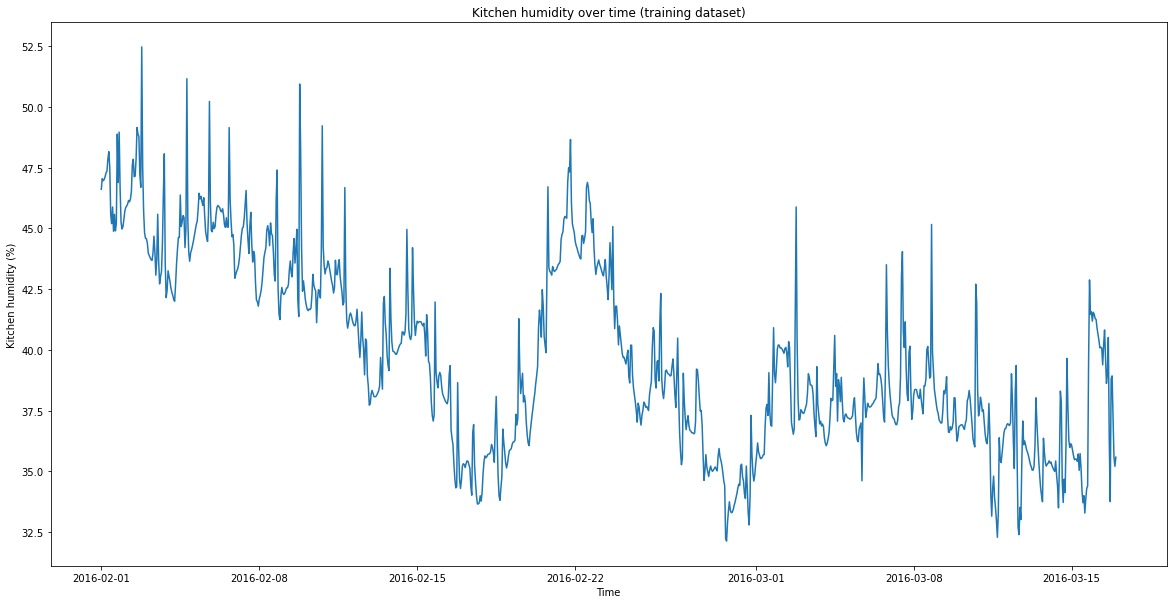

In [35]:
# Plot the training kitchen humidity over time
fig, ax = plt.subplots(figsize=(20, 10))
plot_months(ax, train_data["RH_1"], "Actual humidity")
ax.set_title("Kitchen humidity over time (training dataset)")

To investigate the influence of the passing of the day in hours on the humidity values, we create an hourly boxplot over the training data. We observe that the variation in humidity in general remains similar but rises in the afternoon and evening. Exceptionally higher humidity values are observed at 19h.

Text(0.5, 0.98, 'Kitchen humidity per hour (training dataset)')

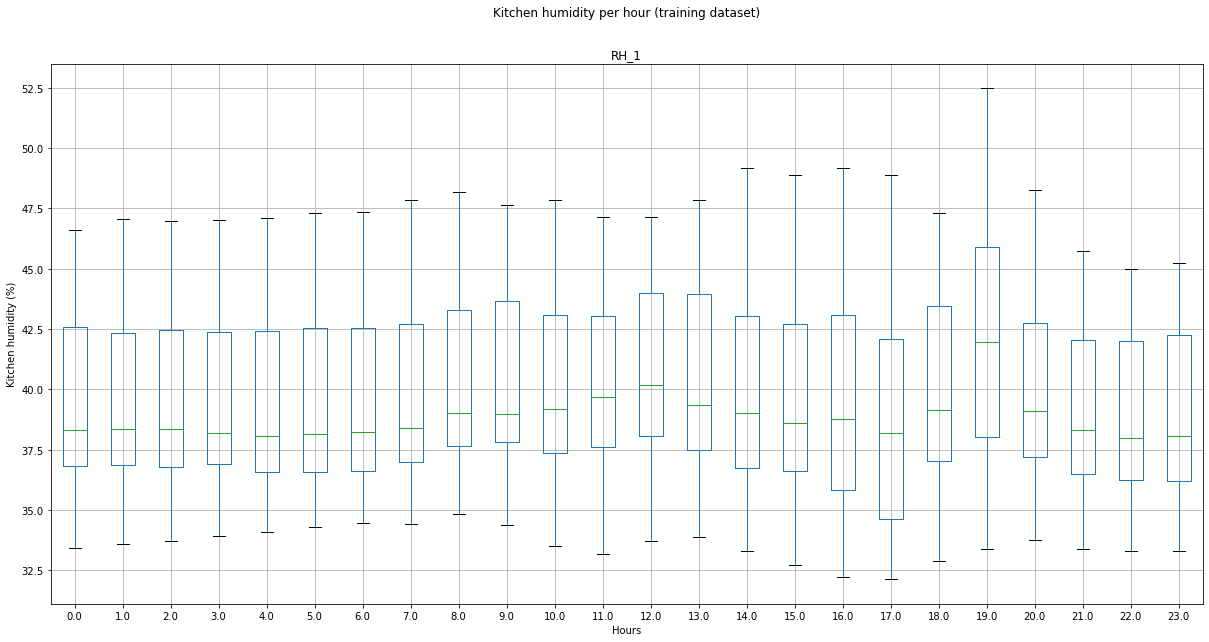

In [36]:
# Plot the training kitchen humidity variation every hour
fig, ax = plt.subplots(figsize=(20, 10))
plot_hours(ax, train_data, "RH_1")
fig.suptitle("Kitchen humidity per hour (training dataset)")

### Training, Testing and Validating

We set up the experiment by creating multiple functions to help us train and evaluate models and to do parameter selection using cross-validation.<br>
The first function aids in measuring the training and test score and error. As this is a regression problem, we use the root-mean-square error
$$E = \sqrt{\dfrac{\sum_{n=0}^N (y_n - h(x_n))^2}{N}}$$
The score is then calculated as follows
$$1-\dfrac{\sum_{n=0}^N (y_n - h(x_n))^2}{\sum_{n=0}^N (y_n - \bar{y})^2}$$
for mean $\bar{y}$. The best possible score is thus 1, but the score may also be negative when the model performs worse than predicting the average $\bar{y}$ over the training set. This function also makes some comparative plots.<br>
The second function creates and evaluates a baseline model with normalisation where using the default hyperparameters.<br>
The third function does a randomised grid search in a parameter grid by sampling a certain number of configurations at random without replacement. Note that the grid search makes use of cross-validation.

The objective of k-fold cross validation is to better approximate $E_{\text{out}}$ by calculating multiple instances of $E_{\text{val}}$ on k smaller training sets. Those k $E_{\text{val}}$'s are then combined by calculating their mean. The image below demonstrates how the training set is split into a training and validation set where k equals to 10. For each of the 10 iterations a different subset is selected as validation set. The rest of the data set is used as training set.
<img src="https://i.imgur.com/auZ6mvi.png" width=500 />
By default, the order of the validation sets is not taken into account. However, for time series data standard k-fold cross validation will not work. It simply doesn't make sense to train a model on data from the future when it will be tested on data from the past. A more logical approach to train the model on historical data and test it on future data. An example of how this is done is displayed in the image below. Each of the four rows corresponds to a different training/validation iteration. In the example the data was split into 4 folds. We will use the same trick in our case as well.
![image-2.png](https://miro.medium.com/max/1204/1*qvdnPF8ETV9mFdMT0Y_BBA.png)
Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

Lastly, in order to not bias our comparison of the two models, the parameter selection explores an equal amount of sample configurations for both.
The best parameter set is then used to train a model on the full training set. Finally, this model is evaluated.

In [37]:
def evaluate_model(model: sklearn.pipeline.Pipeline,
                   X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> None:
	"""
	Evaluate the model by calculating the training and test score and RMSE, plotting the predicted and actual humidity values for the test dataset and full dataset
	and the hourly difference between the predicted and actual humidity values
	:param model: model to evaluate
	:param X_train: training features
	:param X_test: test features
	:param y_train: training labels
	:param y_test: test labels
	:return: None
	"""
	# Calculate the training and test score and RMSE
	print(f"Training score: {model.score(X_train, y_train):.3f}, Test score: {model.score(X_test, y_test):.3f}")
	print(
		f"Training RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.3f} Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.3f}")

	# Give predictions
	test_data["predictions"] = model.predict(X_test)
	test_data["error"] = test_data["RH_1"] - test_data["predictions"]
	train_data["predictions"] = model.predict(X_train)

	# Plot the predicted and actual humidity values for the test dataset
	fig, ax = plt.subplots(figsize=(20, 10))
	plot_months(ax, test_data["RH_1"], "Actual humidity")
	plot_months(ax, test_data["predictions"], "Predicted humidity")
	ax.set_title("Kitchen humidity over time (test dataset)")
	plt.legend()
	plt.plot()

	# Plot the predicted and actual humidity values for the full dataset
	fig, ax = plt.subplots(figsize=(20, 10))
	plot_months(ax, test_data["RH_1"], "Actual humidity (test dataset)")
	plot_months(ax, test_data["predictions"], "Predicted humidity (test dataset)")
	plot_months(ax, train_data["RH_1"], "Actual humidity (training dataset)")
	plot_months(ax, train_data["predictions"], "Predicted humidity (training dataset)")
	ax.set_title("Kitchen humidity over time (full dataset)")
	plt.legend()
	plt.plot()

	# Plot the hourly difference between the predicted and actual humidity values
	fig, ax = plt.subplots(figsize=(20, 10))
	plot_hours(ax, test_data, "error")
	ax.set_title("Kitchen humidity deviation per hour (test dataset)")
	fig.suptitle("")
	plt.plot()


def create_baseline_model(model: DecisionTreeRegressor | KNeighborsRegressor, X_train: pd.DataFrame,
                          y_train: pd.DataFrame, X_test: pd.DataFrame,
                          y_test: pd.DataFrame) -> sklearn.pipeline.Pipeline:
	"""
	Create a baseline model with normalisation and evaluate it
	:param model: model to use
	:param X_train: training features
	:param y_train: training labels
	:param X_test: test features
	:param y_test: test labels
	:return: the trained pipeline
	"""
	model = make_pipeline(StandardScaler(), model)
	model.fit(X_train, y_train)

	evaluate_model(model, X_train, X_test, y_train, y_test)

	return model


def randomize_grid_search(model: sklearn.pipeline.Pipeline, parameters: dict, X_train: pd.DataFrame,
                          y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame,
                          iterations: int) -> RandomizedSearchCV:
	"""
	Randomly search for the best hyperparameters for the given model in a given parameter grid using time series cross validation, fit the best model on the full training set and evaluate it
	:param model: pipeline to use
	:param parameters: parameter grid to search in
	:param X_train: training features
	:param y_train: training labels
	:param X_test: test features
	:param y_test: test labels
	:param iterations: how many samples to do
	:return: the tuned and trained model
	"""
	start = time()
	tuner = RandomizedSearchCV(model, parameters, n_iter=iterations, n_jobs=-2, cv=TimeSeriesSplit(n_splits=5), verbose=1,
	                           scoring="neg_root_mean_squared_error", random_state=0)

	tuner.fit(X_train, y_train)
	print(f"{((time() - start) / 60):.2f} minutes passed")
	print(f"Best cross-validation RMSE: {-tuner.best_score_:.3f}")
	print(f"Best parameters: {tuner.best_params_}")

	evaluate_model(tuner.best_estimator_, X_train, X_test, y_train, y_test)

	return tuner

### The Decision Tree Regressor

We first run the experiment on a baseline decision tree regressor without configuration.

Training score: 1.000, Test score: 0.581
Training RMSE: 0.000 Test RMSE: 1.391


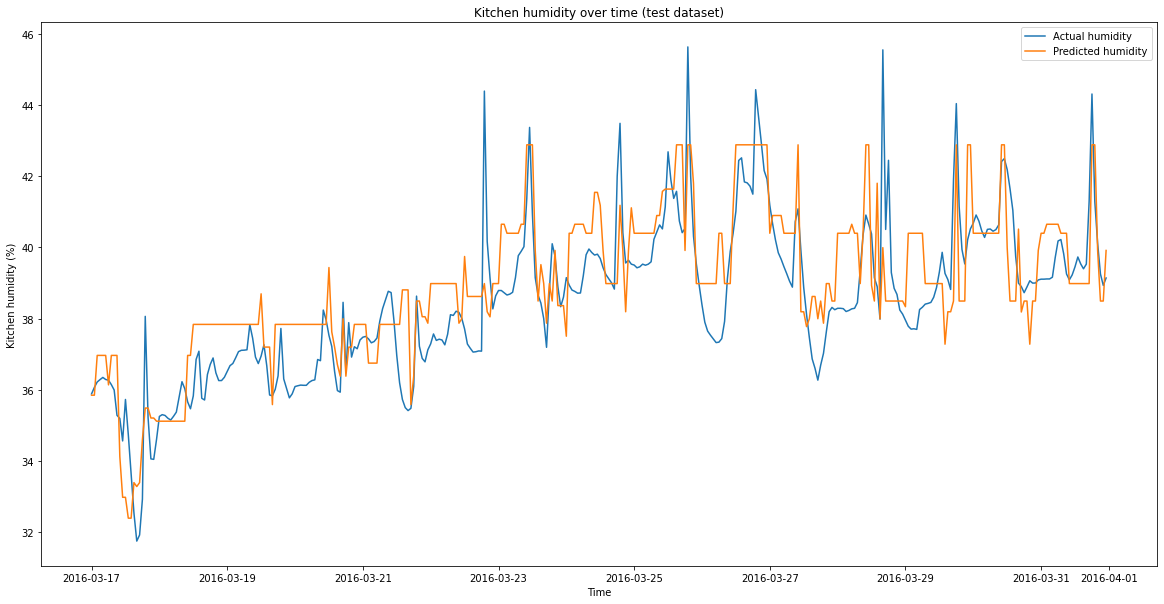

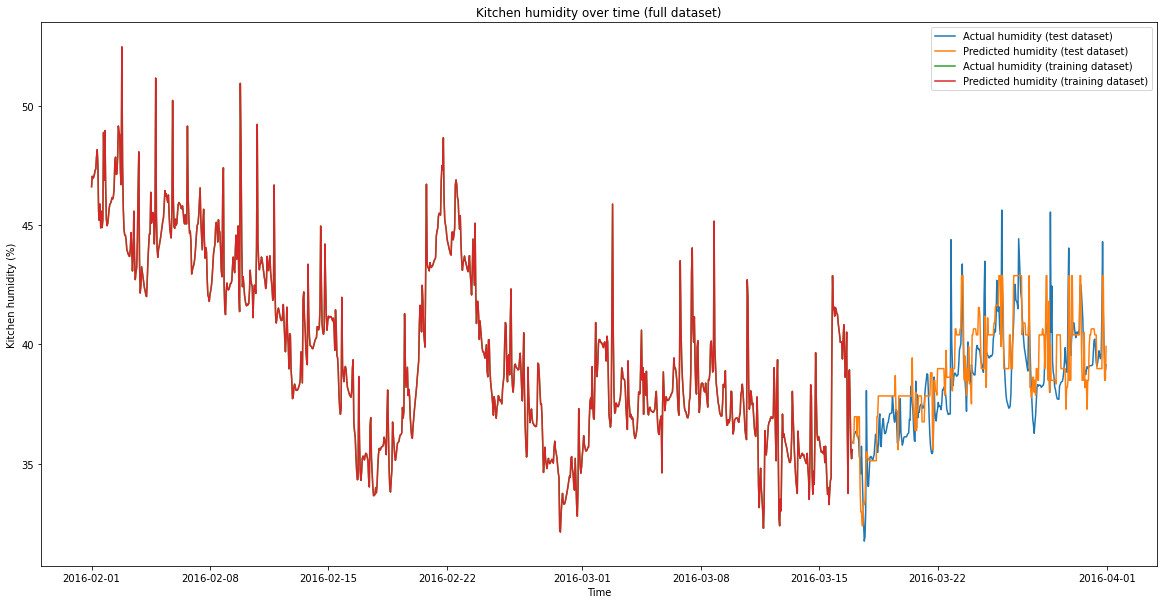

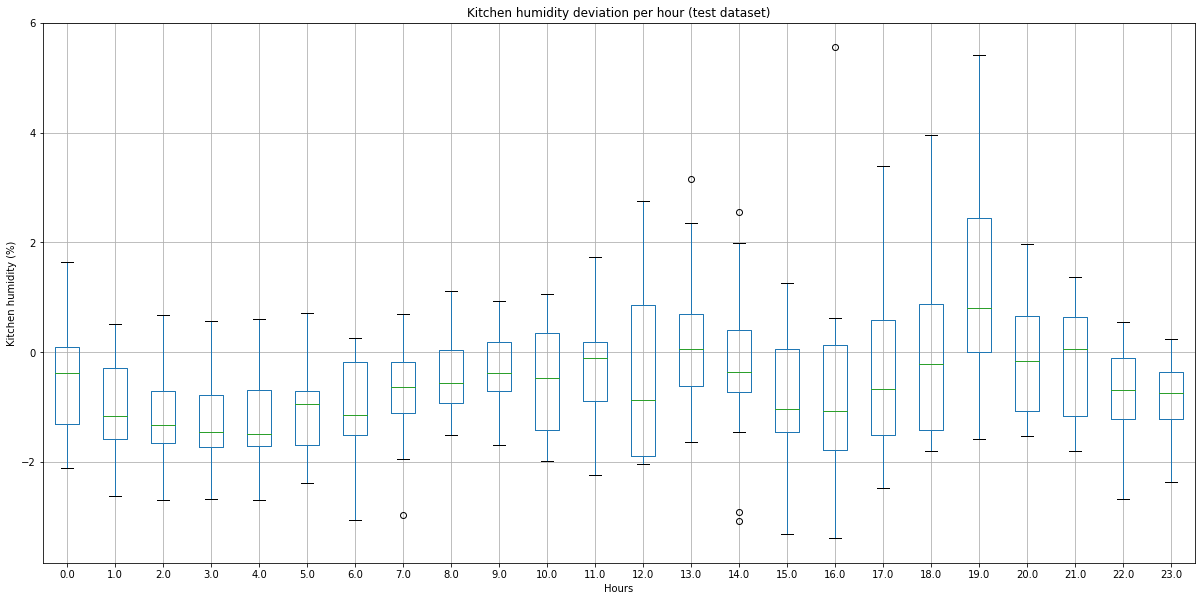

In [38]:
# Create a baseline decision tree regressor and evaluate it
model = DecisionTreeRegressor(random_state=0)

model = create_baseline_model(model, X_train, y_train, X_test, y_test)

The top plot visualises the true and predicted humidity values in function of the time on the test set over approximately two weeks. We see that a general upward trend is correctly predicted by the model based on the features, even though this trend was not really present in the training data. A test score of 0.479 is already obtained with a relatively low error in humidity of 1.551%. This can be recognised in the graph. Although the model is able to predict some smaller fluctuations, the actual bigger peaks cannot. However, sometimes similar peaks are predicted where they do not occur.<br>
A score of 1 and RMSE of 0 indicate that the tree is fitting the training data perfectly. This can also be observed in the second graph. There is good chance the baseline model is actually overfitting the data and picking up noisy features. This might be resolved by applying model selection in the next step.<br>
When looking at the third graph displaying the deviation between the actual and predicted humidity in the test set for every hour, we observe that in general the percentage is overestimated slightly but underestimated for the peak at 19h.

We now select the best parameters for the decision tree regressor based on the training data using time series cross-validation. We sample 1000 configurations from the grid where we consider the following hyperparameters: splitting method,
tree depth, minimum leaf samples, amount of features to consider at every split and the amount of leaf nodes.

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
0.14 minutes passed
Best cross-validation RMSE: 1.851
Best parameters: {'decisiontreeregressor__splitter': 'best', 'decisiontreeregressor__min_samples_leaf': 8, 'decisiontreeregressor__max_leaf_nodes': 40, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': 8}
Training score: 0.949, Test score: 0.554
Training RMSE: 0.871 Test RMSE: 1.434


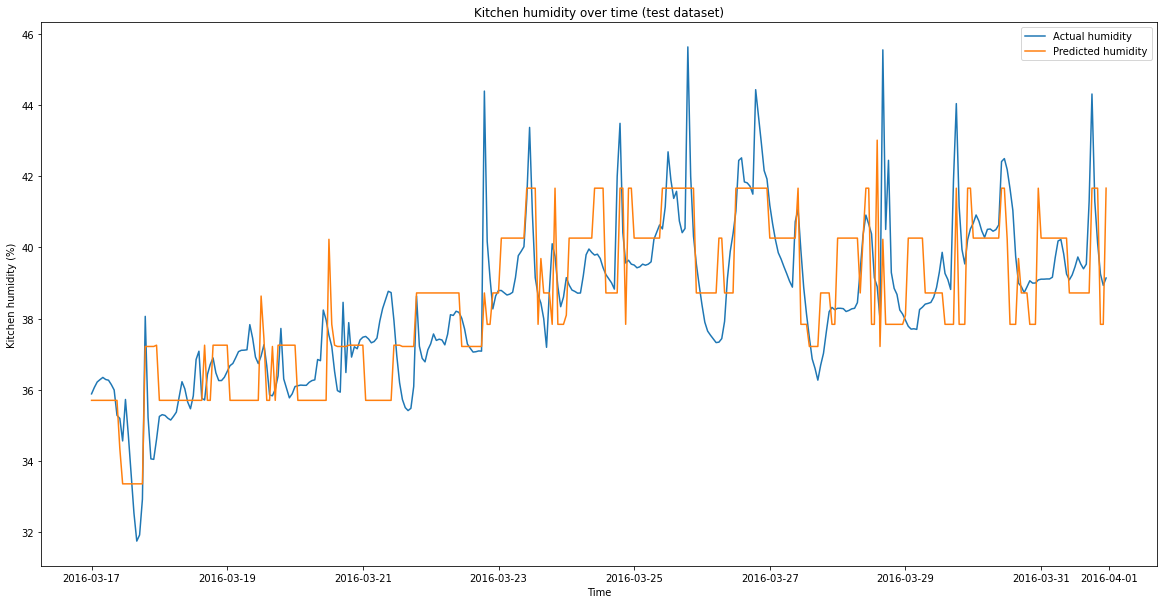

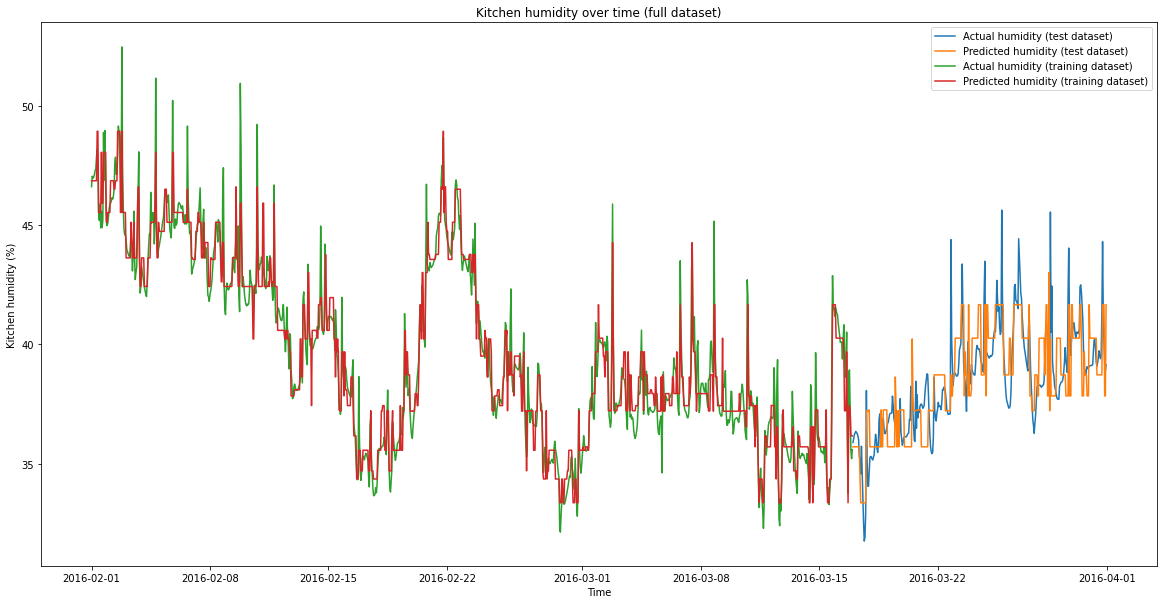

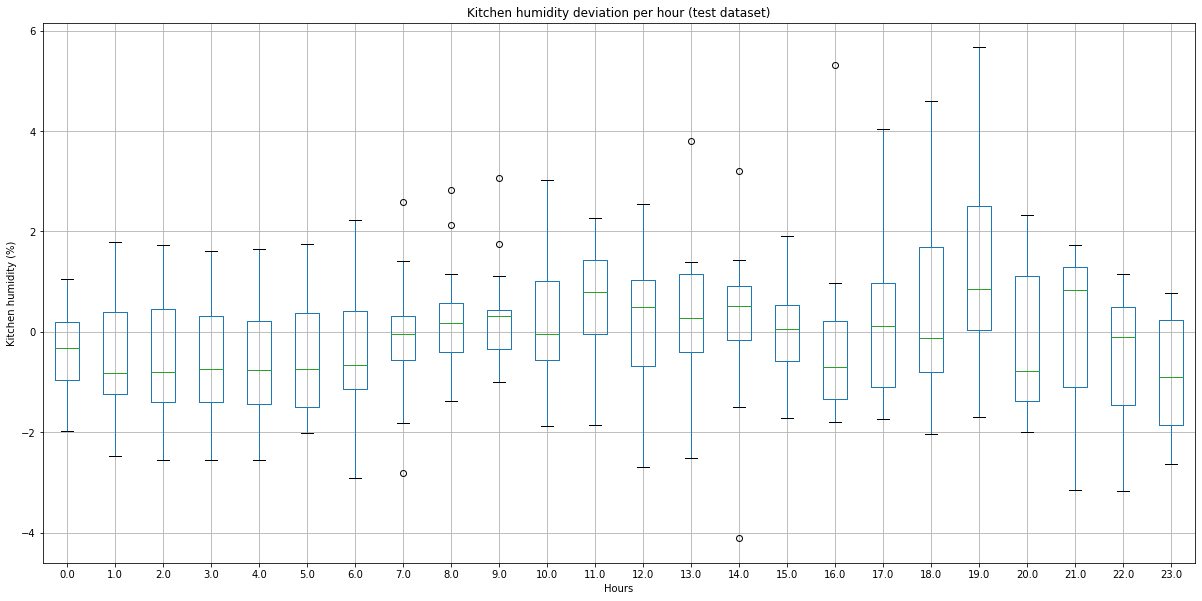

In [39]:
# Do a randomised grid search for the best parameters and evaluate the selected model
parameters = {
	"decisiontreeregressor__splitter": ["best", "random"],  # Split using the squared error criterion or randomly
	"decisiontreeregressor__max_depth": [4, 8, 10, 12, 14, None],  # Maximum depth of the tree
	"decisiontreeregressor__min_samples_leaf": [1, 4, 8, 10, 12],  # Minimum number of samples required a leaf
	"decisiontreeregressor__max_features": [None, "log2", "sqrt"],
	# Number of features to consider when looking for the best split
	"decisiontreeregressor__max_leaf_nodes": [20, 30, 40, 50, 60, None],  # Maximum number of leaf nodes
}

model = randomize_grid_search(model, parameters, X_train, y_train, X_test, y_test, iterations=1000)

By looking at the cross-validation RMSE, we can notice that a simpler, more regularised decision tree is able to generalise better on a dataset of this size. This is accomplished by reducing the tree depth, samples per leave and amount of leaves.<br>
When this model is trained on the full training set it achieves an increased test score of 0.554 and a reduced humidity error of 1.434%. This is a decrease in RMSE of more than 0.1%. Only looking at the graph of the test set, this is perceived by more conservative predictions. The model predicts more flat surfaces (a result of returning the average humidity in a leaf) and is able to recognise potential peaks. However, it avoids predicting wrong extreme humidity values unlike the baseline model.<br>
The regularised model does not fit the training data perfectly anymore, but comes really close with a training score of 0.949. In the second graph, this is recognisable by the fact that the predicted training humidities are less erratic.<br>
When looking at the error in humidity per hour, we now see that the humidities are not overestimated as much anymore although the underestimation at 19h is still present with a large variance in deviation.

### The K-Nearest Neighbours Regressor

The previous experiment is repeated for the k-nearest neighbours regressor. We first establish a baseline model again without configuration.

Training score: 0.945, Test score: 0.040
Training RMSE: 0.908 Test RMSE: 2.105


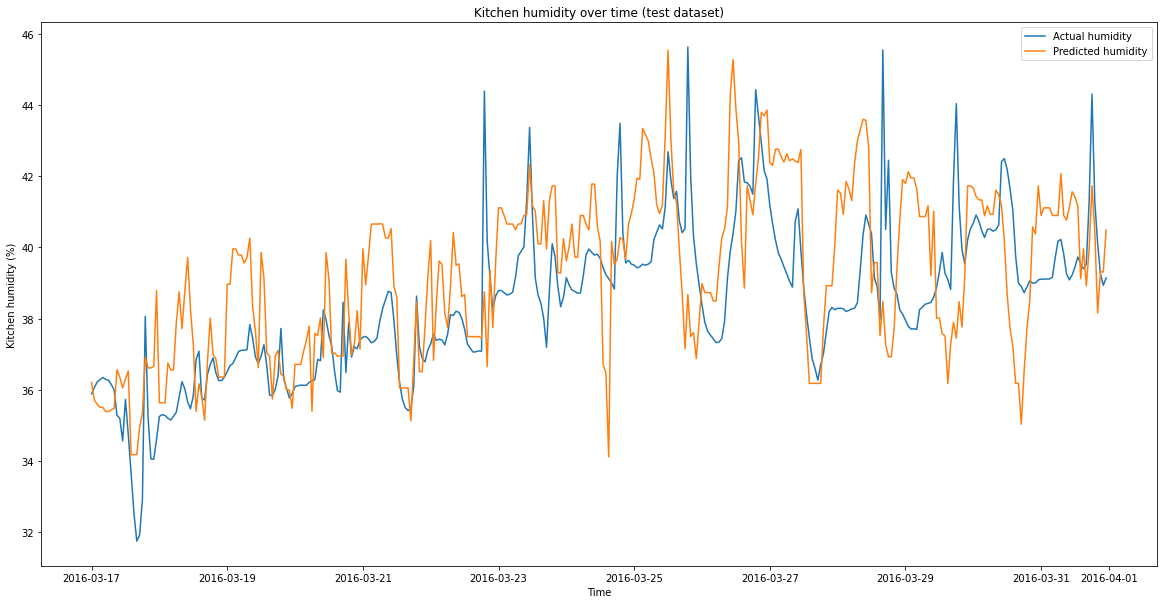

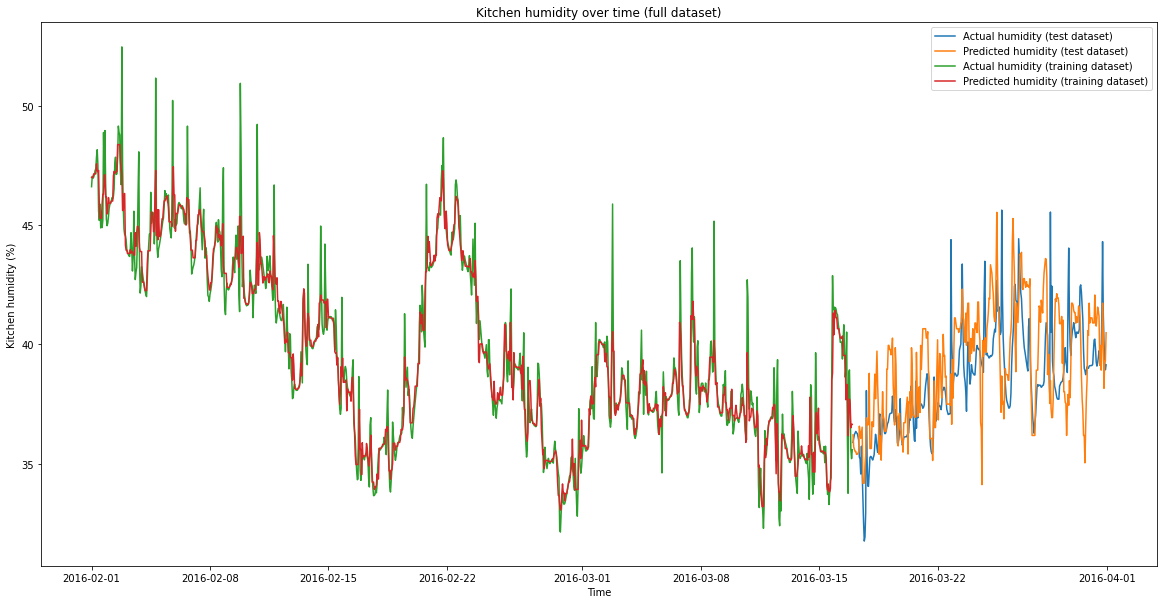

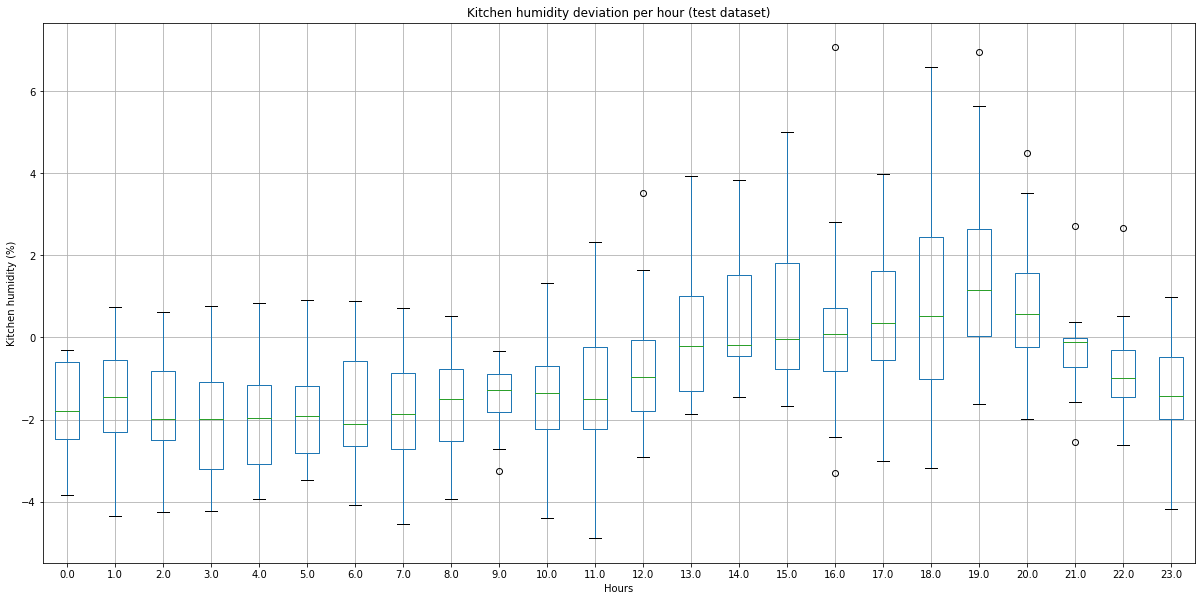

In [40]:
# Create a baseline K-Nearest Neighbors regressor and evaluate it
model = KNeighborsRegressor()

model = create_baseline_model(model, X_train, y_train, X_test, y_test)

As is clear from the first graph, this baseline nearest neighbours model is much more susceptible to the noise present in the training data. As a consequence, the model's test score is only 0.040, barely better than predicting the mean training humidity. The RMSE is above 2% humidity. The predictions on the test set contain multiple large unwarranted peaks and are less in line with the general upward trend.<br>
Looking at the predictions on the training set, we see that this model does not fit the humidity values perfectly (not surprising given that the default amount of neighbours is 5) but comes really close. The extreme humidity values are not fitted.<br>
Similar to the decision tree regressor, the third graph shows that the median hourly prediction is too low while the humidity peaks around 19h are underestimated.

In a similar fashion, we do parameter selection by randomly sampling 1000 parameter configurations from the grid and validating them with cross-validation. We consider the parameters relating to the amount of neighbours, the weighting of the neighbours, the power parameter for the Minkowski metric used, the type of tree datastructure to find the neighbours and the leave size within this tree.

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
0.47 minutes passed
Best cross-validation RMSE: 2.089
Best parameters: {'kneighborsregressor__weights': 'distance', 'kneighborsregressor__p': 1, 'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__leaf_size': 15, 'kneighborsregressor__algorithm': 'kd_tree'}
Training score: 1.000, Test score: 0.089
Training RMSE: 0.000 Test RMSE: 2.050


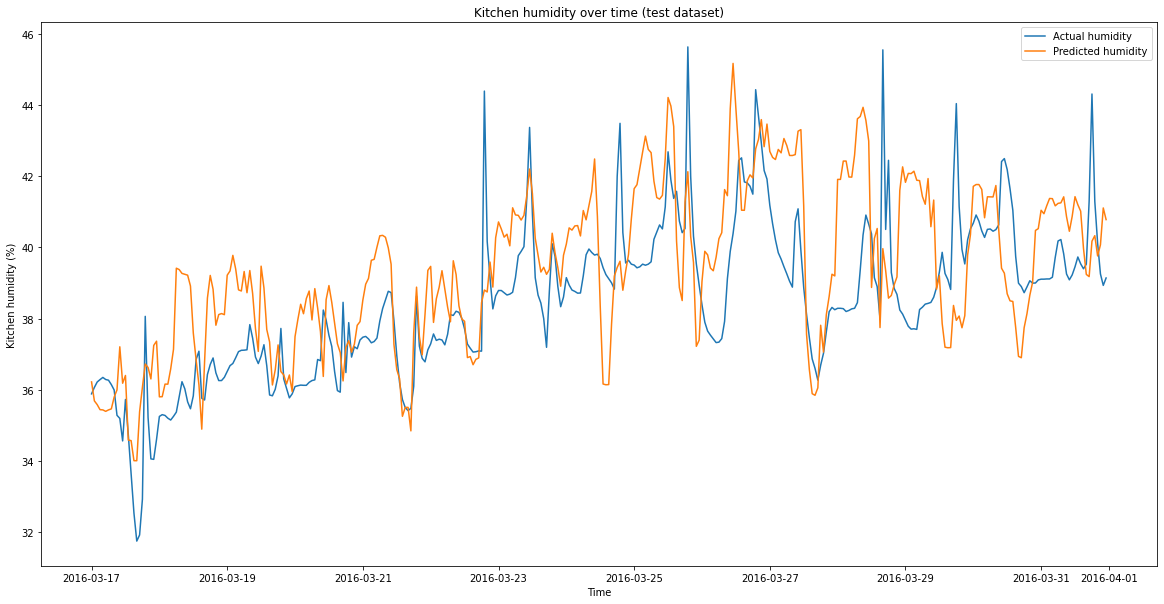

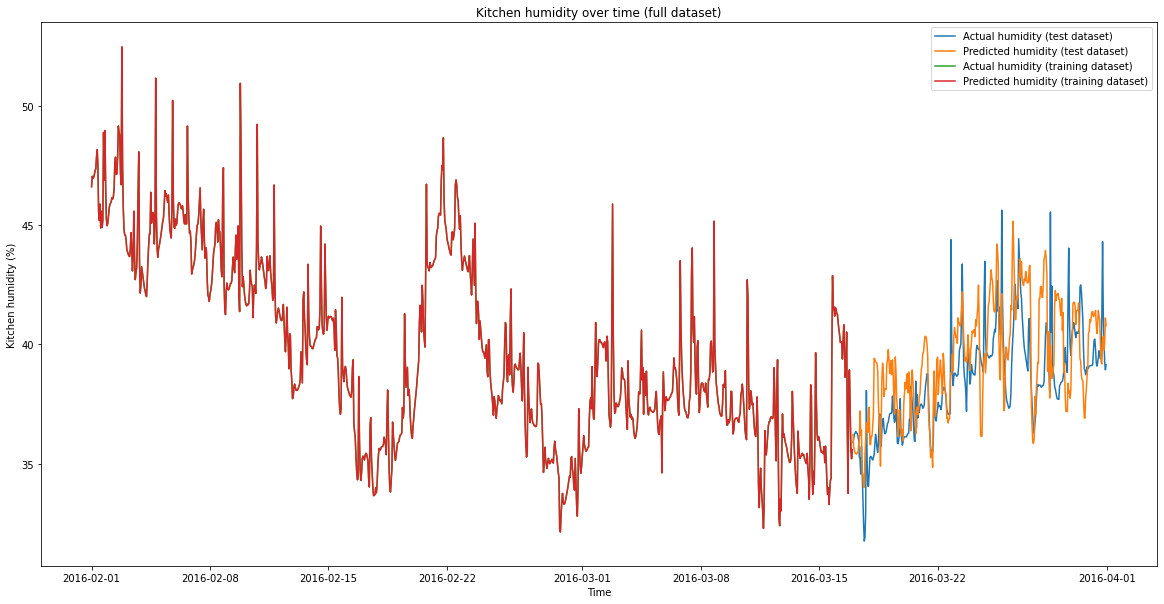

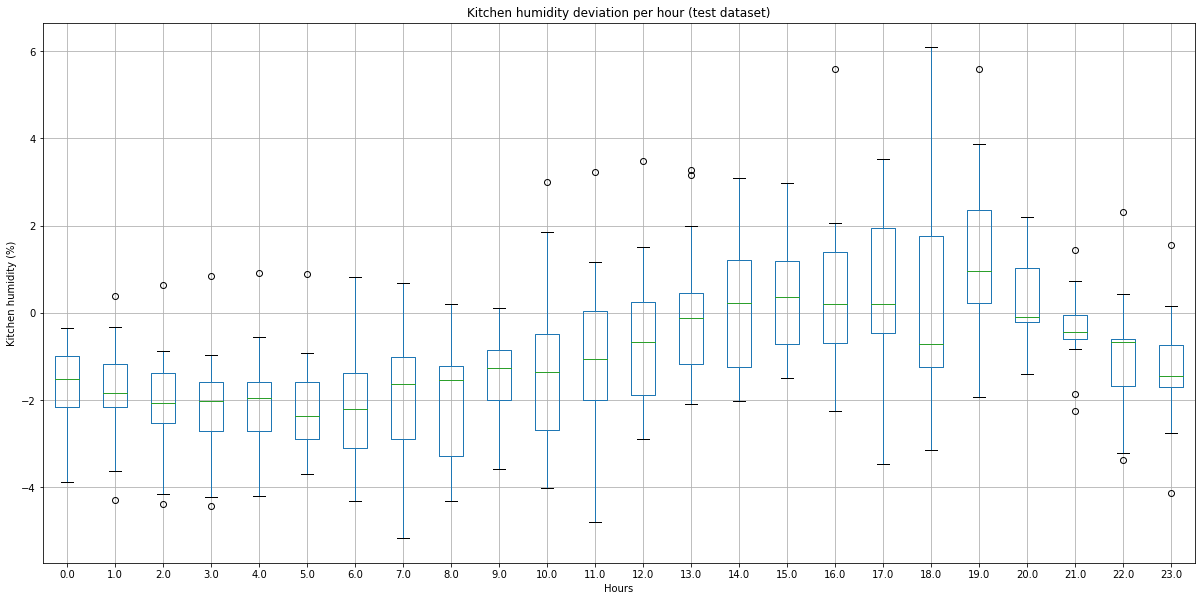

In [41]:
# Do a randomised grid search for the best parameters and evaluate the selected model
parameters = {
	"kneighborsregressor__n_neighbors": [1, 2, 5, 10, 20, 50, 60],  # Number of neighbours to consider
	"kneighborsregressor__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
	# The algorithm and datastructure to find the neigbours
	"kneighborsregressor__weights": ["uniform", "distance"],  # The weight function used in the prediction
	"kneighborsregressor__leaf_size": [1, 2, 5, 10, 15, 20],  # The leaf size of the tree
	"kneighborsregressor__p": [1, 2, 3, 4],  # The power of the Minkowski distance metric
}

model = randomize_grid_search(model, parameters, X_train, y_train, X_test, y_test, iterations=1000)

The best parameter set obtained through selection has a root-mean-square error of 2.089% humidity. Surprisingly, this configured model does fit the training set perfectly, which can be observed in the second graph. This can be explained by the chosen parameter settings. Instead of uniformly weighting the importance of the neighbours, the influence of the points on the prediction is weighted by the inverse of their distance. This is combined with a Manhattan-distance instead of Euclidean distance and the amount of neighbours to be considered is increased.<br>
In this way, the tuned model achieves a slightly increased score of 0.089, still not much better than predicting the mean. But by looking at the graph of the testing set, we see that less extreme jumps in humidity are now avoided, although large fluctuations remain that are not always present in reality. This could be explained by the many jumps present in the dataset for which the Manhattan-distance is close to the test features.<br>
The humidity deviation per hour is very similar to the baseline model, although the variance in deviation has reduced slightly.

### Conclusion

We can conclude that for this dataset of in-house measurements and weather data, a decision tree regressor model selected through cross-validation generalises better to future predictions of humidity percentages than a k-nearest neighbour regressor selected through the same process. <br>
The nature and inner workings of the two regression machine learning models express themselves in their future predictions.
The predictions of the decision tree regressor were smoother with fewer peaks and contained multiple flat surfaces when the depth of the tree was limited. The k-nearest neighbour regressor, on the other hand, was much more susceptible to large fluctuations and noise and it's predictions on the test set, although not correct, resembled more the actual values in the training set.<br>
The nature of time series predictions, in which we mainly try to extrapolate from the training data in the past, makes it so that similar measurements are less relevant than in a standard regression problem. This could potentially explain the poor testing accuracy of the nearest neighbours model.<br>
We have observed that for both regression algorithms, the untuned baseline model's testing accuracy could be increased through parameter selection with time-series cross-validation. In the case of the decision tree, this resulted in a more regularised model that overfitted less. For the k-nearest neighbour model, this was not as obviously visible as the training error actually disappeared while the testing predictions also became a little more stable.<br>
In conclusion, our experiments indicated that the decision tree regressor is a better fit for this type of time series forecasting problem for this particular dataset and behaviour of predicted variable. The prediction accuracy of the model could potentially be improved by preprocessing the data further and removing redundant features. Cross-validation is not only important for model selection, but can help in evaluating these rather manual decisions too.